<a href="https://colab.research.google.com/github/Bhardwaj-Saurabh/customer_support_chatbot_Retail/blob/master/chatbot_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project overview
Customer support chatbot prototype for ShopUNow that combines curated FAQs with LangChain/LangGraph to route and answer employee/customer questions.
- Uses domain-specific FAQs across HR, IT support, facilities/admin, billing/payment, and shipping/delivery as the retrieval corpus.
- Normalizes each FAQ into LangChain `Document` objects and stores embeddings in an in-memory Qdrant vector store for fast semantic search.
- Classifies incoming questions by department and sentiment, then chooses between RAG-generated replies or escalation flows.
- Streams a LangGraph state machine that chains categorization, sentiment analysis, retrieval-augmented response, and optional on-call escalation.
- Designed for notebook experimentation; `OPENAI_API_KEY` is loaded from `.env`, Qdrant is created in memory, and widgets collect escalation details when needed.

## Notebook map
- Setup: sample FAQ corpora per department, env loading, imports.
- Data prep: convert FAQ entries to `Document` objects with department metadata.
- Vector store: embed FAQs with `OpenAIEmbeddings` and ingest into Qdrant via `QdrantManager` helper.
- Agent logic: LangGraph nodes for classification, sentiment, retrieval-based response, and escalation form handling.
- Driver: `call_support_agent` streams events and renders the final Markdown answer.


In [5]:
# @title
import json

hr_data = [
    {
        "doc": "Q: How do I access my annual leave balance?\nA1: Your current annual leave balance is available on the HR employee portal, typically under the 'Leave' or 'Time Off' section. It's updated in real-time after each request is processed.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the process for claiming expenses?\nA2: All work-related expenses can be claimed through the online expense management system, accessible via the Company ShopUNow intranet. You'll need to upload receipts and submit them for manager approval. Please refer to the 'Expense Policy' for detailed guidelines.",
        "category": "HR"
    },
    {
        "doc": "Q: Can I transfer between departments or store locations?\nA3: Internal transfers are possible and encouraged. Keep an eye on internal job postings on the HR intranet. If you see a suitable role, you can apply directly, and your application will be considered alongside external candidates.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the company's policy on equal opportunities and diversity?\nA4: Company ShopUNow is committed to providing equal opportunities and fostering a diverse and inclusive workplace. Our 'Equal Opportunities and Diversity Policy' outlines our commitment to treating all employees fairly, regardless of background.",
        "category": "HR"
    },
    {
        "doc": "Q: How do I report a health and safety concern?\nA5: Any health and safety concerns should be reported immediately to your line manager or a designated Health and Safety representative. You can also log concerns confidentially through the 'Health and Safety' section of the HR intranet.",
        "category": "HR"
    },
    {
        "doc": "Q: What support is available for employee well-being?\nA6: Company ShopUNow offers various well-being initiatives, including an Employee Assistance Program (EAP) providing confidential counselling, mental health resources, and wellness workshops. Details are on the HR intranet under 'Employee Well-being'.",
        "category": "HR"
    },
    {
        "doc": "Q: How are bonuses and incentives calculated?\nA7: Bonus and incentive schemes at Company ShopUNow vary by role and performance metrics. Details regarding your specific scheme, including calculation methods and payout schedules, are communicated by your manager and outlined in your employment contract or relevant policy document.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the policy for extended leave of absence (e.g., sabbatical)?\nA8: Requests for extended leave of absence, such as sabbaticals, are considered on a case-by-case basis and must be approved by your manager and HR. There is a specific 'Extended Leave of Absence Policy' on the HR intranet with eligibility criteria and application procedures.",
        "category": "HR"
    },
    {
        "doc": "Q: How do I request a reference for a new landlord or lender?\nA9: For employment references, please contact the HR department directly via [HR email address] or submit a request through the HR employee portal. Please allow up to [Number] working days for the reference to be provided.",
        "category": "HR"
    },
    {
        "doc": "Q: What resources are available for new employees during onboarding?\nA10: New employees at Company ShopUNow receive a comprehensive onboarding experience, including an induction program, access to the HR intranet with essential company information, and a dedicated buddy or mentor to support their integration.",
        "category": "HR"
    },
    {
        "doc": "Q: How does HR handle employee recognition and rewards?\nA11: Company ShopUNow has a recognition program to celebrate employee achievements. This includes [mention examples like 'employee of the month', 'spot bonuses', or 'service awards']. Details are available on the HR intranet under 'Recognition Programs'.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the process for returning to work after a long-term illness or injury?\nA12: If you have been absent due to long-term illness or injury, HR will work with you and your manager to facilitate a phased return to work plan, including any necessary adjustments. Please contact HR to discuss your return well in advance.",
        "category": "HR"
    },
    {
        "doc": "Q: Where can I find information about company benefits like discounts on products?\nA13: All employees of Company ShopUNow are entitled to a [percentage]% staff discount on all products. Details on how to apply this discount and other retail benefits are available on the HR intranet's 'Benefits' section.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the company's social media policy for employees?\nA14: Company ShopUNow has a 'Social Media Policy' to guide employees on appropriate online conduct, especially when identifying as a company employee. It covers respecting privacy, confidentiality, and maintaining a professional image. The full policy is on the HR intranet.",
        "category": "HR"
    },
    {
        "doc": "Q: How can I provide anonymous feedback or suggestions?\nA15: We offer an anonymous feedback channel, such as an online suggestion box or periodic anonymous surveys, to gather honest input from our employees. Details on how to access these are communicated via internal announcements and the HR intranet.",
        "category": "HR"
    },
    {
        "doc": "Q: What are the company's core values and how do they apply to my work?\nA1: Company ShopUNow's core values are [list 3-5 core values, e.g., 'Customer Focus', 'Teamwork', 'Integrity', 'Innovation']. These values guide our decisions, interactions, and how we serve our customers. You can find more details and examples of how they apply in our 'Company Values and Ethics Policy' on the HR intranet.",
        "category": "HR"
    },
    {
        "doc": "Q: How can I access the company's official policies and procedures?\nA2: All official company policies and procedures are available on the HR intranet under the 'Policies & Procedures' section. You can search by keyword or browse by category. If you can't find what you're looking for, please contact HR.",
        "category": "HR"
    },
    {
        "doc": "Q: Is there a code of conduct for employees?\nA3: Yes, Company ShopUNow has a 'Code of Conduct' that outlines the expected professional and ethical behaviour for all employees. It covers areas like respect, professionalism, and conflicts of interest. It's available on the HR intranet, and all employees are expected to adhere to it.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the process for reporting workplace bullying or harassment?\nA4: Company ShopUNow has a zero-tolerance policy for bullying and harassment. If you experience or witness such behaviour, you should report it immediately to your manager, another manager, or the HR department. Our 'Anti-Bullying and Harassment Policy' on the HR intranet outlines the confidential reporting and investigation procedures.",
        "category": "HR"
    },
    {
        "doc": "Q: How does the company ensure data privacy and security of employee information?\nA5: We take data privacy very seriously. Employee personal data is handled in strict accordance with our 'Data Protection Policy' and relevant regulations (e.g., GDPR in the UK). It's stored securely, accessed only by authorised personnel, and used solely for legitimate business purposes. You can find more information on the HR intranet.",
        "category": "HR"
    },
    {
        "doc": "Q: What should I do if I think there's an error on my payslip?\nA6: If you believe there's an error on your payslip, please contact the HR payroll team immediately, ideally within [e.g., 3-5] working days of receiving it. Provide specific details of the discrepancy, and we will investigate and rectify it as quickly as possible.",
        "category": "HR"
    },
    {
        "doc": "Q: How do I enrol in the company pension scheme?\nA7: As an eligible employee, you will be automatically enrolled in the Company ShopUNow pension scheme after [e.g., 3 months] of employment, in line with statutory requirements. You will receive a welcome pack from the pension provider with options to opt-out or increase your contributions. Contact HR for more details.",
        "category": "HR"
    },
    {
        "doc": "Q: Can I get an advance on my salary?\nA8: Salary advances are generally not provided, except in very extreme and exceptional circumstances and at the sole discretion of the company. Such requests must be submitted in writing to the HR department for review.",
        "category": "HR"
    },
    {
        "doc": "Q: How do I change my tax code or other payroll deductions?\nA9: For changes to your tax code, you'll need to contact HMRC directly. For other payroll deductions (e.g., union fees, charitable donations), please inform the HR payroll team in writing, and we will process the request.",
        "category": "HR"
    },
    {
        "doc": "Q: When can I expect my P60 and P45 forms?\nA10: Your P60 form (End of Year Certificate) will be issued by [date, e.g., 31st May] following the end of the tax year. If you leave the company, your P45 form will be issued shortly after your final pay, typically within [e.g., 1-2 weeks].",
        "category": "HR"
    },
    {
        "doc": "Q: What is the maximum number of consecutive annual leave days I can take?\nA11: The maximum number of consecutive annual leave days you can take is [e.g., 2 weeks or 10 working days], subject to business needs and manager approval. Any requests for longer periods require specific approval from senior management and HR.",
        "category": "HR"
    },
    {
        "doc": "Q: How do I report an unexpected absence due to illness or emergency?\nA12: If you are unable to come to work due to illness or an emergency, you must notify your direct manager by [e.g., 9:00 AM] on the first day of your absence. Follow up with a written notification as soon as possible. Refer to the 'Attendance and Leave Policy' for full details.",
        "category": "HR"
    },
    {
        "doc": "Q: Am I paid for public holidays?\nA13: Yes, eligible employees at Company ShopUNow receive paid leave for recognised public holidays in [e.g., the UK]. If you are required to work on a public holiday, you will receive [e.g., enhanced pay or time off in lieu] as per your contract and the 'Public Holiday Policy'.",
        "category": "HR"
    },
    {
        "doc": "Q: What is compassionate leave and am I eligible for it?\nA14: Compassionate leave is granted to employees for dealing with the death or serious illness of a close family member. Eligibility and the duration of leave vary, and are outlined in the 'Compassionate Leave Policy' on the HR intranet. Please speak to your manager or HR for individual circumstances.",
        "category": "HR"
    },
    {
        "doc": "Q: How does unpaid leave work and when can I request it?\nA15: Unpaid leave may be granted for exceptional personal circumstances, subject to manager and HR approval, and where all paid leave entitlements have been exhausted. Requests should be submitted in writing with a clear reason and proposed duration. The 'Unpaid Leave Policy' details the conditions.",
        "category": "HR"
    },
    {
        "doc": "Q: How often are performance reviews conducted?\nA16: Formal performance reviews are conducted annually for all employees, typically in [Month/Quarter]. However, we encourage regular informal check-ins and feedback sessions between managers and employees throughout the year.",
        "category": "HR"
    },
    {
        "doc": "Q: How can I set personal development goals?\nA17: During your performance review, you'll work with your manager to set SMART (Specific, Measurable, Achievable, Relevant, Time-bound) personal development goals. You can also discuss goals with your manager at any time and document them in your personal development plan.",
        "category": "HR"
    },
    {
        "doc": "Q: Is there a budget for external training courses or conferences?\nA18: Company ShopUNow has a dedicated budget for employee training and development. Requests for external courses or conferences are assessed based on their relevance to your role, alignment with business objectives, and budget availability. Discuss with your manager and submit a 'Training Request Form' to HR.",
        "category": "HR"
    },
    {
        "doc": "Q: How can I get feedback on my performance outside of formal reviews?\nA19: We encourage a culture of continuous feedback. You can proactively ask your manager and colleagues for feedback. Our HR intranet also has resources on giving and receiving constructive feedback effectively.",
        "category": "HR"
    },
    {
        "doc": "Q: What happens if I don't meet my performance targets?\nA20: If you're not meeting performance targets, your manager will work with you to identify the reasons and create a 'Performance Improvement Plan (PIP)'. This plan will outline support, training, and clear expectations for improvement. HR will be involved to ensure a fair process.",
        "category": "HR"
    },
    {
        "doc": "Q: Who should I contact if I have a question about my employment contract?\nA21: For any questions regarding your employment contract, please contact the HR department directly. We can clarify clauses, explain terms, or provide a copy of your contract if needed.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the process for resignation?\nA22: If you decide to resign, you must submit your resignation in writing (email is acceptable) to your line manager and the HR department, adhering to your contractual notice period. HR will then contact you regarding your final pay, benefits, and exit procedures.",
        "category": "HR"
    },
    {
        "doc": "Q: Are there employee committees or groups I can join?\nA23: Yes, Company ShopUNow encourages employee involvement. We have [mention examples like 'Health & Safety Committee', 'Social Committee', 'Diversity & Inclusion Network']. Information on how to join these groups is regularly shared on the HR intranet or notice boards.",
        "category": "HR"
    },
    {
        "doc": "Q: What is the policy on gifts and hospitality from suppliers or customers?\nA24: Our 'Gifts and Hospitality Policy' outlines guidelines for accepting gifts or hospitality from external parties to avoid conflicts of interest. Generally, gifts of nominal value are permissible, but anything substantial must be declared to your manager and HR. The full policy is on the HR intranet.",
        "category": "HR"
    },
    {
        "doc": "Q: Can I volunteer for external charities during work hours?\nA25: Company ShopUNow supports community involvement. We offer [e.g., 'X number of paid volunteer days per year'] for employees to volunteer with registered charities. All requests must be pre-approved by your manager and HR. Please refer to our 'Corporate Social Responsibility Policy'.",
        "category": "HR"
    },
    {
        "doc": "Q: How do I request new software or hardware for my role?\nA26: Requests for new software or hardware should be submitted through the IT helpdesk ticketing system, accessible via the Company ShopUNow intranet. Your manager will need to approve the request, which will then be reviewed by IT and potentially HR for budget and necessity.",
        "category": "HR"
    },
    {
        "doc": "Q: What should I do if I have issues with my HR employee portal access?\nA27: If you are experiencing issues logging into or navigating the HR employee portal, please contact the HR department directly via [HR email/phone number]. We can help troubleshoot or reset your password.",
        "category": "HR"
    },
    {
        "doc": "Q: Is there a policy on personal use of company equipment and internet?\nA28: Yes, our 'IT Usage Policy' covers the appropriate use of company equipment, internet, and email. While reasonable personal use is generally permitted, it should not interfere with work duties or violate any company policies. The full policy is on the HR intranet.",
        "category": "HR"
    },
    {
        "doc": "Q: How can I access internal communication updates (e.g., company news, announcements)?\nA29: Company ShopUNow communicates internal news and announcements primarily through the company intranet homepage, regular team meetings, and specific email newsletters from HR or leadership. Ensure you check these channels regularly.",
        "category": "HR"
    },
    {
        "doc": "Q: Where can I find information about career development resources and tools?\nA30: The HR intranet has a dedicated 'Career Development' section. Here you'll find resources like skill development guides, information on internal mentoring programs, leadership training opportunities, and tools to help you plan your career path within Company ShopUNow.",
        "category": "HR"
    }
]

In [6]:
# @title
it_support_data = [
    # General IT Access & Accounts
    {
        "doc": "Q: I can't log in to my computer/work applications. What should I do?\nA1: First, try restarting your computer. If the issue persists, ensure you're using the correct username and password. If you've forgotten your password or believe your account is locked, please use the 'Forgot Password' link on the login page or contact the IT Helpdesk immediately at [IT Helpdesk Phone Number] or [IT Helpdesk Email].",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I reset my password for my company account?\nA2: You can reset your password securely via the self-service password portal at https://aka.ms/sspr. If you're unable to access this, contact the IT Helpdesk for assistance. For security, never share your password.",
        "category": "IT Support"
    },
    {
        "doc": "Q: My account keeps getting locked out. Why is this happening and how can I prevent it?\nA3: Frequent lockouts can occur due to incorrect password attempts, old credentials saved on devices, or sometimes due to sync issues. Please ensure you update your password on all devices (computer, mobile, tablet) whenever you change it. If it continues, contact IT Helpdesk; we can check for specific lockout triggers.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I request access to a new system or application?\nA4: Access to new systems or applications typically requires approval from your line manager. Once approved, your manager should submit an access request ticket to the IT Helpdesk through the IT Service Portal. Please include the specific system name and your business justification.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I'm a new employee. How do I get my initial IT setup and access?\nA5: Welcome to Company ShopUNow! Your manager should have submitted an IT onboarding request. On your first day, IT will guide you through setting up your computer, email, and initial access to essential systems. If you have any issues, please contact the IT Helpdesk directly.",
        "category": "IT Support"
    },
    # Hardware Support
    {
        "doc": "Q: My computer is running very slow. How can I troubleshoot it?\nA6: Try restarting your computer first. Close unnecessary applications and check your storage space. If it remains slow, it could indicate hardware issues or a need for optimization. Please submit an IT ticket with details about the performance issue, and IT will investigate.",
        "category": "IT Support"
    },
    {
        "doc": "Q: My keyboard/mouse/monitor isn't working. What should I do?\nA7: Check all cables are securely connected. Try restarting your computer. If the issue persists, the peripheral might be faulty. Please log a ticket with the IT Helpdesk, detailing the specific non-functional equipment.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I report a fault with a till (POS) system in the store?\nA8: For any issues with till (Point of Sale) systems, please report it immediately to your Store Manager. They will then follow the established procedure to log an urgent ticket with the IT Helpdesk, providing details of the till number and the nature of the fault.",
        "category": "IT Support"
    },
    {
        "doc": "Q: My company laptop has a cracked screen/physical damage. How do I get it repaired or replaced?\nA9: Accidental damage should be reported to the IT Helpdesk immediately. Please submit a ticket with photos of the damage. IT will assess whether it can be repaired or if a replacement is needed and will guide you through the process.",
        "category": "IT Support"
    },
    {
        "doc": "Q: Can I get a larger monitor or a docking station for my workstation?\nA10: Requests for additional hardware are subject to business justification and approval from your manager and IT. Please discuss your needs with your manager, who can then submit an IT request outlining the business benefit.",
        "category": "IT Support"
    },
    # Software Support
    {
        "doc": "Q: An application I use regularly is crashing or not responding. What's the fix?\nA11: Try closing and reopening the application. If that doesn't work, restart your computer. Ensure your operating system and the application itself are up to date. If the problem continues, log an IT ticket, including the application name and any error messages you see.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I install new software on my company computer?\nA12: Most approved software can be installed via the 'Software Center' (Windows) or 'Self Service' (Mac) on your computer. If the software isn't available there or requires a license, please submit an IT request with a business justification and manager approval.",
        "category": "IT Support"
    },
    {
        "doc": "Q: My Microsoft Office (Word, Excel, Outlook) programs are having issues.\nA13: Try a quick repair of your Office installation via 'Programs and Features' in Control Panel (Windows) or reinstalling the application. If the issue persists, provide a detailed description of the problem and any error messages to the IT Helpdesk via a ticket.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How often are software updates pushed out, and do I need to do anything?\nA14: Software updates (for operating systems and applications) are regularly pushed out by IT to ensure security and performance. Often, they occur automatically overnight or prompt you to restart your computer. Please action these prompts promptly to keep your system secure and efficient.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I need a specific software license for a project. How do I get it?\nA15: Software license requests require manager approval and often budget allocation. Please discuss with your manager, who can then initiate a request through the IT Service Portal, specifying the software and project it's for.",
        "category": "IT Support"
    },
    # Network & Connectivity
    {
        "doc": "Q: My Wi-Fi isn't connecting/is very slow. What should I check?\nA16: Ensure your Wi-Fi is enabled on your device. Try forgetting the network and reconnecting. If it's a general issue, restart your router/access point if safe to do so. If the problem persists for multiple users, it might be a network issue; please report to IT Helpdesk.",
        "category": "IT Support"
    },
    {
        "doc": "Q: The shared network drive isn't accessible. Is it down?\nA17: First, try restarting your computer. If the drive is still inaccessible, it might be a network issue or the server is down. Please contact the IT Helpdesk immediately, providing details of which drive you're trying to access.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I can't print to the office/store printer. What's wrong?\nA18: Check if the printer is on and has paper/toner. Ensure your computer is connected to the correct printer. Try restarting your computer and the printer. If the issue remains, submit an IT ticket with the printer's location and any error messages on its display.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I connect my personal mobile device to the company Wi-Fi network?\nA19: For company Wi-Fi access on personal devices, you typically need to connect to the 'Company ShopUNow Guest' network or follow specific instructions provided by IT for BYOD (Bring Your Own Device) registration. Do not attempt to connect personal devices to the secure internal network without explicit IT guidance.",
        "category": "IT Support"
    },
    {
        "doc": "Q: The internet is completely down in our store/office. What should we do?\nA20: In case of a complete internet outage, immediately notify your Store/Office Manager, who will then contact the IT Helpdesk's emergency line. Provide details on how long it's been down and if any other services are affected. This is a high-priority issue.",
        "category": "IT Support"
    },
    # Security & Data
    {
        "doc": "Q: I received a suspicious email/link. Is it a phishing attempt?\nA21: If you receive a suspicious email, do NOT click on any links or open attachments. Forward the email to [email address for reporting suspicious emails, e.g., phishing@companyshopunow.com] and then delete it from your inbox. Never provide personal or login information in response to unsolicited emails.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I think my computer might have a virus or malware. What should I do?\nA22: Disconnect your computer from the network (unplug the Ethernet cable or turn off Wi-Fi) immediately to prevent further spread. Then, report it to the IT Helpdesk with details of what you've observed. Do not attempt to fix it yourself.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How are company data and my files backed up?\nA23: Company data stored on shared network drives and in approved cloud storage (e.g., SharePoint, OneDrive) is automatically backed up regularly by IT. Files saved locally on your desktop or 'My Documents' folder on your computer are NOT automatically backed up; please ensure you save important work to network drives or approved cloud storage.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I access company resources (e.g., shared drives, internal apps) when working remotely?\nA24: When working remotely, you must connect via the company's Virtual Private Network (VPN). Instructions for installing and connecting to the VPN are available on the IT section of the intranet. If you encounter issues, contact the IT Helpdesk.",
        "category": "IT Support"
    },
    {
        "doc": "Q: What is the company's policy on removable media (USB drives)?\nA25: Our 'Data Security Policy' restricts the use of unapproved removable media (e.g., personal USB drives) to prevent data loss or malware introduction. If you need to use a USB, it must be company-issued and scanned by IT. Transferring company data to personal USBs is strictly prohibited.",
        "category": "IT Support"
    },
    # Communication & Collaboration Tools
    {
        "doc": "Q: My company email isn't sending or receiving messages. What's wrong?\nA26: Check your internet connection. Try restarting Outlook/your email client. If you're using webmail, try clearing your browser's cache. If the issue persists, submit an IT ticket with details of any error messages or specific symptoms (e.g., can send but not receive).",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I set up my company email on my mobile phone?\nA27: Instructions for setting up company email on approved mobile devices (iOS/Android) are available on the IT intranet. We recommend using the designated company email app (e.g., Outlook Mobile). For security, your device may need to meet certain IT compliance standards.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I'm having trouble with Microsoft Teams/company chat software.\nA28: Try restarting the application. Check your internet connection. Ensure your microphone/camera settings are correct within Teams itself. If the problem persists, log an IT ticket with details of the issue (e.g., audio not working, messages not sending).",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I share large files with colleagues or external partners securely?\nA29: For internal sharing, use shared network drives or Microsoft SharePoint/OneDrive. For external sharing of large files, use approved company cloud storage platforms with secure sharing links (e.g., OneDrive links with expiration dates). Avoid using personal file-sharing services for company data. Consult the 'Data Sharing Policy' or IT for guidance.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How can I request a new video conferencing license for external meetings?\nA30: Most employees have access to standard video conferencing capabilities (e.g., Teams/Zoom basic). If you require advanced features or a dedicated license for frequent external meetings, discuss this with your manager and submit an IT request outlining the business need.",
        "category": "IT Support"
    },
    # Device Management & Lifecycle
    {
        "doc": "Q: My company laptop/desktop is getting old and slow. How can I request an upgrade or replacement?\nA1: Company ShopUNow operates a hardware refresh cycle, typically every [e.g., 3-4] years. If you believe your device is impacting your productivity significantly before the refresh cycle, discuss it with your manager. They can then submit an IT request for assessment and potential early replacement, based on business need.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I'm leaving the company. What do I need to do with my company IT equipment?\nA2: When you leave Company ShopUNow, all company-issued IT equipment (laptops, phones, peripherals) must be returned to IT. Your manager will coordinate the return process with IT, which typically happens on your last day. Please ensure all personal files are removed from the device before returning it.",
        "category": "IT Support"
    },
    {
        "doc": "Q: Can I install personal software or games on my company computer?\nA3: No, installing personal software or games on company-issued computers is strictly prohibited as per our 'IT Acceptable Use Policy'. This is to maintain system security, stability, and compliance with software licenses. Unauthorized software will be removed.",
        "category": "IT Support"
    },
    {
        "doc": "Q: My work phone is damaged/lost. How do I get a replacement?\nA4: Immediately report a damaged or lost work phone to the IT Helpdesk and your manager. For lost phones, IT will remotely wipe the device if possible. A replacement will be arranged based on our mobile device policy; fees may apply for negligence.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I connect a new external device (e.g., webcam, microphone) to my company laptop?\nA5: For common peripherals, your computer should automatically install the necessary drivers. If not, or if it's a specialized device, contact the IT Helpdesk via a ticket. Do not install drivers from unknown sources.",
        "category": "IT Support"
    },
    # Network & Connectivity (Advanced)
    {
        "doc": "Q: I'm experiencing frequent disconnections from the VPN. What could be the cause?\nA6: Frequent VPN disconnections can be due to unstable home internet, a weak Wi-Fi signal, or issues with the VPN client. Try restarting your router and computer. If it persists, log an IT ticket with details of your internet provider and location, and IT can help troubleshoot the connection.",
        "category": "IT Support"
    },
    {
        "doc": "Q: Our store's network is experiencing intermittent slowdowns. Who should I contact?\nA7: For intermittent network slowdowns affecting multiple systems or users in a store, report it to your Store Manager, who will then escalate it as an urgent priority to the IT Helpdesk, providing specific details of the affected systems and timeframes.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I connect to a specific shared network folder that I've been granted access to?\nA8: You can usually connect to shared network folders by typing the network path (e.g., `\\\\server\\sharename`) into your Windows Explorer address bar or by mapping it as a network drive. If you have trouble accessing it after being granted permission, contact IT Support with the full path.",
        "category": "IT Support"
    },
    {
        "doc": "Q: We need to set up a temporary network connection for an event in the store. Can IT assist?\nA9: Yes, IT can assist with planning and setting up temporary network connections for approved company events. Please submit an IT request well in advance, detailing the event, location, required bandwidth, and duration, so we can assess and prepare.",
        "category": "IT Support"
    },
    {
        "doc": "Q: My headset isn't working for calls on Teams/Zoom. What are common fixes?\nA10: Check if the headset is properly plugged in (or paired if Bluetooth). Ensure it's selected as the default input/output device in your computer's sound settings AND within the Teams/Zoom application settings itself. Try restarting the application or your computer. If issues persist, contact IT.",
        "category": "IT Support"
    },
    # IT Security & Compliance
    {
        "doc": "Q: What is the company's policy on remote work and IT security?\nA11: Our 'Remote Work IT Security Policy' outlines requirements for secure remote access, including mandatory VPN use, strong passwords, and protecting company data on personal networks. It also provides guidelines for home network security and physical security of company equipment.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I accidentally clicked on a suspicious link. What should I do immediately?\nA12: If you accidentally clicked a suspicious link, immediately disconnect your computer from the internet (unplug network cable/turn off Wi-Fi). Then, report the incident to the IT Helpdesk and your manager without delay. Do not try to access sensitive information or continue working on that device.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How often should I change my password, and what are the password requirements?\nA13: Our 'Password Policy' requires passwords to be changed every [e.g., 90] days. Passwords must be at least [e.g., 12] characters long, contain a mix of uppercase letters, lowercase letters, numbers, and special characters. Do not reuse old passwords.",
        "category": "IT Support"
    },
    {
        "doc": "Q: Are personal cloud storage services (like Dropbox, Google Drive) allowed for company data?\nA14: No, using personal cloud storage services for company data is strictly prohibited due to security and compliance risks. All company data must be stored on approved company network drives or official cloud collaboration platforms (e.g., Company ShopUNow's SharePoint/OneDrive for Business).",
        "category": "IT Support"
    },
    {
        "doc": "Q: How can I securely dispose of old company documents or data?\nA15: For physical documents, use the designated shredding bins in the office/store. For digital data on company devices, IT handles secure data wiping. Do not attempt to wipe or dispose of company hard drives yourself. Consult IT for guidance on data disposal.",
        "category": "IT Support"
    },
    # Software & Application Specific
    {
        "doc": "Q: My email inbox is full. How can I manage my mailbox size?\nA16: You can manage your mailbox size by deleting unnecessary emails, especially those with large attachments. Consider archiving older emails to your local machine (if allowed) or using online archives provided by IT. Consult the 'Email Usage Policy' on the IT intranet for best practices.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I need to conduct an online meeting with external participants. Which tool should I use?\nA17: For online meetings with external participants, use Company ShopUNow's approved platforms such as Microsoft Teams or Zoom (if licensed). These platforms offer secure meeting features and are supported by IT. Avoid using unapproved personal video conferencing tools for company business.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How do I request a software patch or update for a specific business application?\nA18: Software patches and updates for critical business applications are managed centrally by IT. If you believe a specific patch is needed or an update is causing issues, please report it to the IT Helpdesk with details of the application and the observed problem.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I'm having trouble with a specific retail software (e.g., inventory management, CRM). Who do I contact?\nA19: For issues with specific retail software, first check if there's an internal super-user or department lead. If not, or if it's a technical error, contact the IT Helpdesk, providing the software name, version, and exact error message/problem.",
        "category": "IT Support"
    },
    {
        "doc": "Q: Can IT help with setting up or troubleshooting my personal home printer for work?\nA20: IT Support primarily focuses on company-issued equipment. While we can offer basic guidance, we are not equipped to fully troubleshoot or support personal home printers. We recommend using company-approved printing solutions.",
        "category": "IT Support"
    },
    # IT Service & Support Processes
    {
        "doc": "Q: How do I check the status of an IT ticket I've submitted?\nA21: You can check the status of your IT tickets by logging into the IT Service Portal at https://ut.service-now.com/sp?id=ut_sc_home. You will see a list of your submitted tickets and their current status, along with any comments from the IT team.",
        "category": "IT Support"
    },
    {
        "doc": "Q: Is there an IT knowledge base or FAQ I can refer to before logging a ticket?\nA22: Yes! The IT section of the Company ShopUNow intranet contains a comprehensive knowledge base and FAQ section with guides for common issues, how-to articles, and troubleshooting tips. We encourage you to check there first.",
        "category": "IT Support"
    },
    {
        "doc": "Q: What are IT's working hours, and what happens if I have an urgent issue outside of hours?\nA23: IT Helpdesk standard working hours are [e.g., 8 AM - 5 PM, Monday to Friday]. For urgent issues outside of these hours (e.g., critical system outage impacting sales), please refer to the emergency contact procedure outlined on the IT intranet or leave a message on the urgent helpdesk line.",
        "category": "IT Support"
    },
    {
        "doc": "Q: Can I bring my personal laptop to work and connect it to the company network?\nA24: Connecting personal laptops to the company's internal network is generally not permitted for security reasons. If there's a specific business need, it must be pre-approved by IT and may require specific security configurations. Refer to the BYOD policy.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I need to request a specific data export or report from a company system. Who handles this?\nA25: For standard reports, check if the system itself has reporting capabilities. If you need a custom data export or complex report, submit a request to the IT Helpdesk, detailing the data required, the system it's from, and the business purpose. Data governance rules apply.",
        "category": "IT Support"
    },
    # IT Training & Awareness
    {
        "doc": "Q: Does IT provide training on new software or IT systems?\nA26: Yes, IT provides training when new software or significant system changes are implemented. We also have online training modules and guides available on the IT intranet for common applications and cybersecurity awareness. Contact IT if you have specific training needs.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How can I learn more about cybersecurity best practices for my role?\nA27: IT regularly provides cybersecurity awareness training, including mandatory annual online modules. You can also find tips and guidelines on phishing prevention, secure password practices, and data protection on the IT intranet's 'Cybersecurity Hub'.",
        "category": "IT Support"
    },
    {
        "doc": "Q: I'm not familiar with using [specific software]. Is there a quick guide?\nA28: For commonly used software, IT often creates quick reference guides or links to official documentation on the IT intranet. Check the 'Software Guides' section. If you can't find what you need, submit an IT ticket, and we can point you to resources or arrange basic assistance.",
        "category": "IT Support"
    },
    {
        "doc": "Q: How does IT communicate planned system maintenance or outages?\nA29: IT communicates planned system maintenance, upgrades, or potential outages via email announcements, notifications on the company intranet, and sometimes messages within critical applications. We aim to provide ample notice for any scheduled downtime.",
        "category": "IT Support"
    },
    {
        "doc": "Q: What is the process for suggesting IT improvements or new technologies?\nA30: We welcome suggestions for IT improvements or new technologies that could benefit Company ShopUNow. Please submit your ideas via the 'IT Suggestion Box' on the IT Service Portal, providing details on the proposed solution and its potential business benefits. Relevant suggestions will be reviewed by the IT management team.",
        "category": "IT Support"
    }
]

In [7]:
# @title
facility_and_admin_data = [
    {
        "doc": "Q: How do I report a maintenance issue in the office/store (e.g., a broken light, leaky tap)?\nA1: You can report any maintenance issues via the Facilities Request Portal on the company intranet. Please provide as much detail as possible, including location and a description of the problem. For urgent issues that pose an immediate safety risk, please also notify your manager and contact Facilities directly at [Facilities Urgent Phone Number].",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Who do I contact if the air conditioning/heating isn't working properly?\nA2: Please submit a Facilities Request via the portal, specifying the affected area and the nature of the issue (e.g., too hot, too cold, no airflow). This allows our team to log the issue and dispatch the appropriate technician.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I request office supplies or stationery?\nA3: You can request office supplies through the online Stationery Order Form, accessible on the Facilities & Admin section of the intranet. Orders are typically processed weekly, so please plan your requests in advance.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What's the policy on using the kitchen facilities (e.g., microwaves, fridges)?\nA4: Our kitchen facilities are for shared use. Please ensure you clean up after yourself, label personal items in the fridge, and dispose of rubbish appropriately. There's a 'Kitchen Etiquette' guide posted in all kitchen areas and on the intranet for full details.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Where can I find information about emergency procedures (fire, evacuation)?\nA5: Emergency procedures, including fire escape routes, assembly points, and designated fire wardens, are clearly displayed throughout the office/store locations. You can also find a comprehensive 'Emergency Preparedness Guide' on the Facilities & Admin section of the intranet. Regular drills are also conducted.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I book a meeting room?\nA6: Meeting rooms can be booked using the Outlook Calendar's 'Room Finder' feature. Simply select the room you wish to book as you would invite an attendee to a meeting. Please remember to release the room if your meeting is cancelled.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Is there a lost and found for personal items?\nA7: Yes, the central Lost & Found is managed by the Facilities & Admin team. Please bring any found items to [specific location, e.g., the Reception Desk or Facilities Office]. If you've lost an item, check there or contact Facilities directly.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What are the catering options for internal meetings or events?\nA8: For internal meetings or events requiring catering, you can submit a catering request through the Facilities Request Portal. Please specify the date, time, number of attendees, and dietary requirements. Lead times apply, so plan ahead.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Are there facilities for bicycle storage or showers for commuters?\nA9: Yes, we provide secure bicycle storage racks at [specific location, e.g., the rear of the building/basement car park]. Showers are available in the [specific location, e.g., basement/gym area] for staff convenience. Please refer to the 'Commuter Facilities Guide' on the intranet.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I request a new desk, chair, or ergonomic assessment?\nA10: If you require a new desk, chair, or believe you need an ergonomic assessment due to discomfort, please discuss this with your manager. Your manager can then submit a request to Facilities & Admin, who will arrange an assessment or procure necessary equipment.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: I've lost my access card/fob. How do I get a replacement?\nA11: Report a lost access card/fob immediately to Facilities & Admin or Security. Your old card will be deactivated, and a new one will be issued. A replacement fee may apply as per the 'Access Control Policy'.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I get visitor access for an external guest?\nA12: All visitors must be pre-registered through the Visitor Management System, accessible via the Facilities & Admin section of the intranet. This ensures a smooth check-in process and appropriate security measures. Visitors must check in at Reception upon arrival.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What are the procedures for after-hours access to the office/store?\nA13: After-hours access is typically restricted to authorised personnel with valid access cards. If you need to work outside standard hours, ensure you follow the 'After-Hours Access Policy', which may include signing in/out or notifying security. Always ensure doors are securely locked when leaving.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I report a security concern or suspicious activity?\nA14: Immediately report any security concerns, suspicious activity, or unauthorized individuals to Security personnel (if on-site) or call [Security Control Room Phone Number] and your manager. For non-urgent concerns, you can use the Facilities Request Portal.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Is there CCTV monitoring in the premises?\nA15: Yes, Company ShopUNow operates CCTV monitoring in various areas of our premises for security, safety, and loss prevention purposes. Signage is displayed where CCTV is in operation, in line with our 'CCTV Policy' and data protection regulations.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I dispose of confidential documents securely?\nA16: Confidential documents must be placed in the designated secure shredding bins located throughout the office/store. Please do not dispose of sensitive information in regular waste bins. Facilities & Admin arrange for regular, certified shredding services.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What are the recycling guidelines for different types of waste?\nA17: We have clear recycling bins for paper, plastics, glass, and general waste in all kitchen and office areas. Specific guidelines on what can be recycled are posted above the bins and detailed in our 'Environmental & Recycling Policy' on the intranet.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I dispose of old electronic waste (e-waste) like old phones or keyboards?\nA18: Do not dispose of e-waste in general bins. Please collect old electronic equipment and label it for e-waste disposal. Contact Facilities & Admin to arrange for proper collection and environmentally responsible recycling.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What is Company ShopUNow doing to be more environmentally friendly?\nA19: Company ShopUNow is committed to sustainability through various initiatives, including enhanced recycling programs, energy-saving measures, and reducing waste. Our 'Sustainability Report' and ongoing initiatives are detailed on the intranet's 'Environmental Policy' section.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Can I bring personal items like coffee pods or batteries for recycling at work?\nA20: We encourage staff to recycle. We have specific collection points for common items like batteries in the staff room. For other personal recyclables, please use public recycling facilities unless specific company collection points are provided. Check with Facilities if unsure.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I book business travel (flights, hotels, rental cars)?\nA21: All business travel bookings must be made through our approved corporate travel agency [Agency Name/Portal Link]. Please refer to the 'Travel Policy' on the intranet for guidelines on booking classes, expenses, and approval procedures.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Who handles incoming and outgoing mail/packages?\nA22: Incoming mail and packages are received and sorted by the Facilities & Admin team at Reception. Outgoing mail and packages (for business purposes) can be left at Reception, ensuring they are correctly addressed and labelled. Consult the 'Mail & Courier Policy' for details.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I arrange for a courier service for urgent documents/packages?\nA23: For urgent business courier services, please complete a 'Courier Request Form' on the Facilities & Admin intranet page. Provide details of the item, destination, and urgency. Our team will arrange collection and provide tracking information.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What are the guidelines for displaying notices or posters in the office/store?\nA24: All notices or posters for display in common areas must be approved by Facilities & Admin to ensure compliance with company branding and safety regulations. Please submit your request for approval and display guidance.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Can Facilities help with moving office equipment or furniture?\nA25: Yes, for moving office equipment or furniture, please submit a Facilities Request detailing the items and locations. Our team will coordinate the move, ensuring it's done safely and efficiently, often outside of core working hours to minimize disruption.",
        "category": "Facilities & Admin"
    },
    # Additional common questions
    {
        "doc": "Q: What's the protocol for visitors needing Wi-Fi access?\nA26: Guests can access our 'Company ShopUNow Guest Wi-Fi' network. The password is displayed at the Reception desk or can be provided by the Receptionist. It's for general internet Browse only and does not provide access to internal company resources.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Is there a first aid station, and who are the first aiders?\nA27: Yes, designated first aid stations are located at [specific locations, e.g., Reception, Staff Room, Store Manager's Office]. Certified first aiders are identifiable by their badges and their names are listed on notice boards and the Facilities & Admin intranet page. For emergencies, contact a first aider or call [Emergency Number].",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I request a new business card?\nA28: New business card requests can be submitted through the Marketing/Brand portal, which is managed in conjunction with Facilities & Admin. You will need manager approval, and details like your name, title, and contact information.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What should I do if I smell gas or see a potential fire hazard?\nA29: If you smell gas or see a fire hazard, immediately follow emergency procedures: activate the nearest fire alarm and evacuate the building. Do NOT attempt to investigate or handle the situation yourself. Then, notify emergency services [Emergency Number] and Facilities & Admin/Security.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How can I provide feedback or suggestions regarding facilities services?\nA30: We welcome your feedback! You can submit suggestions via the 'Facilities Feedback Form' on the intranet, or directly contact a member of the Facilities & Admin team. We also conduct periodic surveys to gather your input on our services.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: My workstation's power outlets aren't working. How do I get them fixed?\nA1: If your power outlets are not functioning, please submit a Facilities Request via the online portal. Detail the location of your workstation and the issue. Our maintenance team will investigate and arrange for repair or an electrician.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I report a pest control issue (e.g., insects, rodents) in the building?\nA2: Any sightings of pests should be reported immediately to Facilities & Admin via an urgent request on the portal or by calling [Facilities Urgent Phone Number]. We have a regular pest control service, but prompt reporting helps address specific infestations quickly.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What's the process for requesting a new key for an office/storage room?\nA3: New key requests must be approved by your department head and then submitted to Facilities & Admin using the 'Key Request Form' on the intranet. All keys are logged and issued according to our 'Key Control Policy' for security purposes.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How are common areas (e.g., reception, hallways) cleaned, and how often?\nA4: Our cleaning contractors service common areas daily outside of core business hours to minimize disruption. This includes vacuuming, dusting, sanitizing surfaces, and emptying bins. Specific cleaning schedules are available from Facilities upon request.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What should I do if a toilet is blocked or overflowing?\nA5: For any plumbing issues, especially blocked or overflowing toilets, please report it immediately as an urgent maintenance request via the Facilities Portal, or call the urgent Facilities line directly. This requires immediate attention to prevent further damage.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: We are expecting new hires. How do we arrange for their workstations?\nA6: Your manager should submit an 'Onboarding Facilities Request' through the portal as soon as a new hire is confirmed. This ensures that a workstation, IT setup, and access passes are prepared for their start date. Please allow at least [e.g., 5] working days' notice.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Can I reconfigure my office space or desk layout?\nA7: Minor adjustments to your personal workstation furniture are generally permissible. For significant reconfigurations of office space, team moves, or purchasing new furniture, please discuss with your manager, who can then submit a detailed request to Facilities for planning and approval.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What is the process for disposing of old or unused office furniture?\nA8: Please do not dispose of office furniture yourself. If you have old or unused furniture, submit a 'Furniture Disposal Request' to Facilities. We will arrange for its removal, reuse, or environmentally responsible disposal.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: We need more storage space for our department. How do we request it?\nA9: If your department requires additional storage space, discuss your needs with your manager. A formal request outlining the quantity and type of items needing storage, and justification, should be submitted to Facilities & Admin for review and allocation.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Is hot-desking or flexible seating available in certain areas?\nA10: Yes, Company ShopUNow offers hot-desking or flexible seating in [mention specific areas, e.g., 'the marketing hub' or 'designated quiet zones']. Guidelines for hot-desking, including booking procedures and etiquette, are available on the Facilities & Admin intranet section.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How can I report excessive energy use or lights left on?\nA11: If you notice excessive energy consumption, such as lights left on in unoccupied rooms or equipment running unnecessarily, please report it to Facilities & Admin. You can use the general maintenance request form and specify 'Energy Waste' as the issue.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Does the company use renewable energy sources?\nA12: Company ShopUNow is actively exploring and implementing renewable energy solutions where feasible, as part of our commitment to sustainability. Details on our current energy sources and targets are available in the 'Annual Sustainability Report' on the intranet.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How can I contribute to reducing our environmental footprint at work?\nA13: You can contribute by ensuring lights and equipment are turned off when not in use, recycling correctly, conserving water, and using public transport or cycling. Participate in our 'Green Team' initiatives – details are on the intranet.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Are there initiatives to reduce water consumption in the facilities?\nA14: Yes, Facilities actively implements water-saving measures, such as installing low-flow fixtures and conducting regular leak detection. Employees are encouraged to report leaks promptly and be mindful of water usage. Our 'Water Conservation Policy' is on the intranet.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How does the company manage its carbon emissions?\nA15: Company ShopUNow measures and works to reduce its carbon emissions through various strategies, including energy efficiency upgrades, optimizing logistics, and promoting sustainable transport. Our progress and targets are outlined in the 'Sustainability Report' available on the intranet.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: I need to send a registered/certified mail. How do I arrange this?\nA16: For registered or certified mail for business purposes, bring the item to the Facilities & Admin reception desk. You'll need to fill out a brief form, and we will process the sending, ensuring it's tracked appropriately.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What support can Facilities & Admin provide for an internal company event?\nA17: Facilities & Admin can assist with internal company events by arranging room setup, catering coordination, AV equipment setup, cleaning services, and access control. Please submit an 'Event Support Request' on the portal well in advance of your event.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How do I get documents laminated or bound?\nA18: Facilities & Admin provides basic laminating and binding services for official company documents. Please bring your documents to the Admin office with a completed 'Document Services Request Form' detailing your requirements.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Can I request a company vehicle for business travel?\nA19: Company vehicles are available for authorised business travel, subject to availability and our 'Fleet Management Policy'. To request a vehicle, complete the 'Vehicle Request Form' on the Facilities & Admin intranet page. You must have a valid driver's license.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What is the process for receiving large deliveries (e.g., pallets of stock for office use)?\nA20: For large deliveries of non-retail stock intended for office or internal use, please notify Facilities & Admin in advance. Provide supplier details, estimated arrival time, and contents so we can prepare for receipt and storage. Deliveries should be scheduled during working hours.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How often are fire drills conducted, and is attendance mandatory?\nA21: Fire drills are conducted periodically throughout the year to ensure all employees are familiar with evacuation procedures. Attendance is mandatory for all personnel on-site during a drill to comply with health and safety regulations.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: I noticed a slip/trip hazard. Who should I tell?\nA22: Immediately report any slip, trip, or fall hazards (e.g., spilled liquid, loose carpet) to your immediate manager and Facilities & Admin. If possible, cordon off the area to prevent accidents while awaiting cleanup or repair.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Is there a defibrillator (AED) on site, and where is it located?\nA23: Yes, a defibrillator (AED) is available on site for medical emergencies. It is located at [specific, prominent location, e.g., 'the main reception desk' or 'next to the first aid station']. Staff are encouraged to know its location.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How does Facilities ensure the cleanliness and hygiene of restrooms?\nA24: Restrooms are cleaned multiple times throughout the day by our dedicated cleaning team, with particular attention to sanitization and replenishment of supplies. We encourage employees to report any issues promptly via the Facilities Request Portal.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What should I do if a guest or visitor has a medical emergency on company premises?\nA25: In a medical emergency involving a guest or visitor, immediately call for a first aider and emergency services ([Emergency Number, e.g., 999 in UK]). Then, inform Facilities & Admin or Security, who can provide further support and assist emergency personnel.",
        "category": "Facilities & Admin"
    },
    # Other common or specific retail-related admin/facilities queries
    {
        "doc": "Q: What's the policy on personal decorations or items at my desk/workstation?\nA26: Employees are permitted to personalize their immediate workstation with a reasonable number of personal items or decorations, provided they do not pose a safety hazard, are not offensive, and do not impede cleaning or maintenance. Please refer to the 'Workspace Tidiness Policy' on the intranet.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How is internal signage (e.g., directional signs, notice boards) managed?\nA27: Facilities & Admin manages all internal signage to ensure consistency and compliance. If you need new directional signs or want to post official notices, please submit a request to Facilities & Admin, outlining the purpose and proposed content.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: Can Facilities assist with external contractors coming to work on our premises?\nA28: Yes, all external contractors (e.g., for repairs, installations) must be pre-arranged and managed by Facilities & Admin. Please notify Facilities well in advance if you plan to engage any external contractors for work on company property.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: What is the process for handling mail that arrives for former employees?\nA29: Mail for former employees should be returned to the sender if possible. If the sender is not clear, please pass it to Facilities & Admin or HR, who will manage its appropriate disposal or forwarding.",
        "category": "Facilities & Admin"
    },
    {
        "doc": "Q: How can I access the first aid kit if I need a minor plaster or bandage?\nA30: Basic first aid kits for minor injuries (like plasters, antiseptic wipes) are available at the main first aid stations and often in designated areas within each department/store. Please replenish items by notifying your first aider or Facilities & Admin.",
        "category": "Facilities & Admin"
    }
]

In [8]:
# @title
billing_and_payment_data = [
    {
        "doc": "Q: How can I view my past orders and their billing details?\nA1: You can view your past orders and their associated billing details by logging into your 'My Account' section on the Company ShopUNow website. Navigate to 'Order History' where each order will show its status, items, and billing summary.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: I see a charge from 'Company ShopUNow' on my bank statement that I don't recognize. What should I do?\nA2: Please check your 'My Account' order history for any recent purchases. If you still don't recognize the charge, please contact our Customer Service team immediately at [Customer Service Phone Number] or via email at [Customer Service Email] with the date and amount of the charge. We will investigate this for you.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Do you send paper invoices or are they all digital?\nA3: To minimize our environmental impact, Company ShopUNow primarily issues digital invoices and order confirmations via email. You can also access and download them from your 'My Account' section online.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How do I get a copy of my invoice for a previous purchase?\nA4: You can download and print invoices for all your past purchases directly from the 'Order History' section within your 'My Account' on our website. Each order will have a link to 'View Invoice' or 'Download Receipt'.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Why was I charged a different amount than the price shown on the product page?\nA5: This can happen due to various reasons such as sales tax, shipping fees, or if a discount code expired or was incorrectly applied. Please review your order confirmation email, which details all charges. If you still believe there's an error, contact Customer Service with your order number.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What payment methods do you accept?\nA6: Company ShopUNow accepts a wide range of payment methods, including major credit and debit cards (Visa, Mastercard, American Express), PayPal, Apple Pay, and Google Pay. We also offer [mention any buy-now-pay-later options, e.g., Klarna, Clearpay] for eligible purchases.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: My payment failed during checkout. What should I do?\nA7: If your payment failed, please check your card details for any typos, ensure sufficient funds, or try a different payment method. Your bank might also have declined the transaction; contact them for clarification. If the issue persists, our Customer Service team can assist.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I pay for my online order using a gift card?\nA8: Yes, Company ShopUNow gift cards can be used as a payment method during online checkout. Simply enter your gift card number and PIN in the designated field.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Do you offer 'buy now, pay later' options?\nA9: Yes, we partner with [e.g., Klarna, Clearpay] to offer flexible 'buy now, pay later' options for eligible purchases. You can select this as a payment method at checkout and follow their instructions for approval.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I split my payment across multiple credit cards?\nA10: Currently, our online system does not support splitting payments across multiple credit cards for a single order. You would need to use one primary payment method per transaction.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How long does it take for a refund to process and appear on my statement?\nA11: Once your return is received and processed, refunds typically take [e.g., 5-10] business days to appear on your original payment method statement. Processing times can vary depending on your bank or credit card provider.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: I returned an item, but haven't received my refund yet. What should I do?\nA12: Please allow up to [e.g., 10] business days from the date your return was confirmed as received for the refund to process. If it has been longer, please contact Customer Service with your order and return tracking number, and we will investigate.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: If I return part of an order that qualified for a discount, how is my refund calculated?\nA13: If you return part of an order that qualified for a discount (e.g., 'buy one get one free' or 'spend X save Y'), your refund will be adjusted to reflect the items you keep at their original price, or the revised discount based on the remaining items. Details will be explained in your refund confirmation.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Will my shipping fees be refunded if I return an item?\nA14: Shipping fees are generally non-refundable unless the return is due to a Company ShopUNow error (e.g., incorrect or damaged item received). Please refer to our 'Returns Policy' for full details.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: I paid with a gift card and returned an item. How will my refund be issued?\nA15: Refunds for purchases made with a gift card will be issued back to a new digital gift card or directly to the original gift card if it remains active. You will receive the gift card details via email.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: I was charged twice for the same order. How can I get this fixed?\nA16: We apologize for any double charges. Please contact our Customer Service immediately with your order number and proof of the duplicate charge (e.g., a screenshot of your bank statement). We will investigate and issue a refund for the erroneous charge promptly.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: The price of an item dropped shortly after I purchased it. Can I get a price adjustment?\nA17: Company ShopUNow offers price adjustments under certain conditions. If an item you purchased goes on sale within [e.g., 7] days of your purchase, please contact Customer Service with your order number, and we will review your eligibility for a refund of the difference. Exclusions may apply during major sales events.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How do I dispute an incorrect charge on my Company ShopUNow bill?\nA18: If you believe a charge is incorrect, please gather your order details and contact Customer Service immediately. Provide the specific charge you are disputing and your reason. We will open an investigation and work with you to resolve the issue.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: My discount code didn't apply at checkout. Can it be applied after the order is placed?\nA19: Unfortunately, discount codes generally cannot be applied after an order has been placed as the payment has already been processed. Please ensure your discount code is correctly entered and applied before completing your purchase. If you experienced a technical issue, contact Customer Service.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I get a refund if I purchased a product and then found a better deal elsewhere?\nA20: Our standard returns policy applies. If the item is unused and within the return window, you may return it for a refund as per our 'Returns Policy'. We do not typically match competitor pricing after a purchase has been made.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Is my credit card information stored securely on your website?\nA21: Yes, Company ShopUNow takes your payment security very seriously. We use industry-standard encryption (SSL/TLS) to protect your payment details during transmission. Your full credit card number is never stored on our servers; only tokenized versions are kept for secure processing.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How do I update my saved payment methods in my account?\nA22: You can update or remove saved payment methods by logging into your 'My Account' and navigating to the 'Payment Methods' or 'Wallet' section. Here you can add new cards or delete existing ones.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What should I do if I suspect fraudulent activity on my Company ShopUNow account?\nA23: If you suspect any fraudulent activity, immediately change your account password. Then, contact our Customer Service team at [Customer Service Phone Number] or [Customer Service Email] to report the activity. We will investigate and take necessary security measures.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Do you use 3D Secure (e.g., Visa Secure, Mastercard Identity Check) for online payments?\nA24: Yes, for your security, Company ShopUNow utilizes 3D Secure protocols (such as Verified by Visa and Mastercard Identity Check) for online credit and debit card transactions. This adds an extra layer of authentication during checkout.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I remove my saved payment information from my account completely?\nA25: Yes, you have the option to remove any saved payment methods from your 'My Account' at any time. Simply go to the 'Payment Methods' section and select the option to delete the card.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How do I manage or cancel a subscription I have with Company ShopUNow?\nA26: If you have a subscription (e.g., for a book club or regular DIY supply delivery), you can manage or cancel it by logging into your 'My Account' and navigating to the 'Subscriptions' section. You'll find options to modify or cancel your recurring order there.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: When will my recurring subscription payment be charged each month/period?\nA27: Your recurring subscription payment will be charged on the same day of the month/period that you initially signed up, or on the day your first order was placed. You can view your next billing date in the 'Subscriptions' section of your 'My Account'.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I update the payment method for my subscription?\nA28: Yes, you can update the payment method for your active subscription by logging into your 'My Account', going to the 'Subscriptions' section, and selecting the option to 'Update Payment Method' for your specific subscription.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What happens if my subscription payment fails?\nA29: If a subscription payment fails, you will receive an email notification from Company ShopUNow. We will typically attempt to re-charge your payment method a few times. If it continues to fail, your subscription may be paused or cancelled. Please update your payment information promptly.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Are there any fees for cancelling a subscription?\nA30: Company ShopUNow's subscription cancellation policy varies depending on the specific subscription service. Please review the terms and conditions of your particular subscription on our website or within your 'My Account' for any associated cancellation fees or notice periods.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Is VAT (Value Added Tax) included in the prices shown on your website?\nA1: Yes, for customers within the UK, all prices displayed on the Company ShopUNow website are inclusive of VAT at the current standard rate. The breakdown will be shown at checkout and on your invoice.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: If I'm shopping from outside the UK, will I be charged VAT or local taxes?\nA2: For international orders, VAT will be removed at checkout. However, you will be responsible for any applicable local import duties, customs fees, or taxes in your country upon delivery. We advise checking your local customs office for details before placing an order.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What currency will I be charged in if I'm an international customer?\nA3: All transactions on the Company ShopUNow UK website are processed in Great British Pounds (GBP). If you are paying with an international card, your bank will convert the GBP amount to your local currency, and they may apply their own conversion rates and fees.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How are currency exchange rates handled if I pay with a foreign card?\nA4: When paying with a foreign card, the currency exchange rate used will be determined by your bank or payment provider at the time the transaction is processed. Company ShopUNow is not responsible for these rates or any associated foreign transaction fees your bank may charge.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I get a VAT receipt for my business?\nA5: Yes, all our digital invoices serve as valid VAT receipts for businesses. You can download these from your 'My Account' section under 'Order History'. If you require specific business details to be on the invoice, please ensure your account details are updated before purchase.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Why do I see a 'pending' or 'authorization' charge on my bank statement?\nA6: When you place an order, your bank may place a temporary 'pending' or 'authorization' hold on your funds for the purchase amount. This is not an actual charge but reserves the funds. The actual charge occurs when your order is dispatched. The hold usually drops if the order is cancelled or expires after a few days.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: My order was cancelled, but the charge is still on my bank statement. When will it disappear?\nA7: If your order was cancelled, the pending authorization hold on your funds will typically be released by your bank within [e.g., 3-5] business days. This is not a charge and will disappear automatically; it will not appear as a refund. If it persists longer, please contact your bank.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I pay with a bank transfer or direct debit?\nA8: Currently, Company ShopUNow does not support direct bank transfers or direct debits for standard online retail purchases. We accept major credit/debit cards, PayPal, and other digital payment methods as listed on our checkout page.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Why was my payment declined, even though I have sufficient funds?\nA9: Payment declines can occur for several reasons, even with sufficient funds. Common reasons include: incorrect card details, bank's fraud prevention systems, card expiry, or exceeding daily transaction limits. Please contact your bank directly for specific reasons for the decline.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I change the payment method after I've placed an order?\nA10: Once an order has been placed and payment authorized, the payment method generally cannot be changed. If you need to use a different payment method, you would need to cancel the existing order (if possible before dispatch) and place a new one.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How do my loyalty points affect my billing?\nA11: If you are a member of the Company ShopUNow loyalty program, any loyalty points redeemed during checkout will be applied as a discount to your order total before the final payment is processed. The reduced amount will then be charged to your chosen payment method.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: My gift card isn't working at checkout. What could be the problem?\nA12: Ensure you are entering the correct gift card number and PIN. Check if the gift card has sufficient balance or if it has expired. If issues persist, please contact Customer Service with your gift card details.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I combine multiple gift cards on a single purchase?\nA13: Yes, you can typically combine multiple Company ShopUNow gift cards on a single purchase during checkout. Simply enter each gift card number and PIN one by one.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What is store credit, and how do I use it?\nA14: Store credit is a non-cash balance issued by Company ShopUNow, often for returns without a receipt or as a goodwill gesture. It's usually linked to your customer account and can be applied as a payment method during checkout for future purchases.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I get a cash refund for a gift card or store credit balance?\nA15: Gift cards and store credit balances are typically non-refundable for cash. They can only be redeemed for purchases at Company ShopUNow. Please refer to the specific terms and conditions of your gift card or store credit.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: I need to change my order before it ships. How will this affect my billing?\nA16: If you modify your order before it ships, any changes to the total cost will be reflected in your final charge. If the cost decreases, the original authorization hold may be reduced, or a partial refund issued. If it increases, a new authorization for the additional amount may be processed.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: When will I be charged for a pre-order?\nA17: For pre-orders, Company ShopUNow typically places an authorization hold on your payment method at the time of order placement to verify funds. The actual charge will only occur when your pre-ordered item is ready to ship.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I update the payment method for a pre-order if my card expires before release?\nA18: Yes, if your payment method for a pre-order is due to expire, you can update it by logging into your 'My Account' and navigating to your 'Pre-orders' or 'Payment Methods' section. We recommend doing this well in advance of the release date to avoid delays.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: If an item on my pre-order is cancelled by Company ShopUNow, will I be charged for the rest of the order?\nA19: If an item from your pre-order is cancelled by us, you will not be charged for that specific item. The rest of your pre-order will proceed as planned, and you will only be charged for the items that are shipped.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What happens if a pre-ordered item's price changes before release?\nA20: If the price of a pre-ordered item changes before its release, Company ShopUNow will honor the price you originally paid at the time of your pre-order placement. You will not be charged more if the price increases, nor will you receive a refund if it decreases.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Why do I sometimes need to complete an extra security check (e.g., bank OTP) during checkout?\nA21: This extra step is part of 3D Secure (e.g., 'Verified by Visa', 'Mastercard Identity Check'), which adds an additional layer of security to online transactions. It's your bank's way of verifying that you are the legitimate cardholder, protecting you from fraud.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How can I protect myself from phishing emails related to billing from Company ShopUNow?\nA22: Be suspicious of emails asking for personal or payment information directly. Company ShopUNow will never ask for your full card number or password via email. Always check the sender's email address and hover over links before clicking. If in doubt, go directly to our official website to log in or contact Customer Service.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Do you store my CVV/CVC code for credit cards?\nA23: For your security, Company ShopUNow does NOT store your CVV/CVC (the 3 or 4-digit security code on the back of your card). You will need to re-enter this code for each transaction, even if other card details are saved.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What is a chargeback, and how does it work with Company ShopUNow?\nA24: A chargeback is when you dispute a transaction directly with your bank or card issuer. We encourage you to contact Company ShopUNow Customer Service first to resolve any issues. If you initiate a chargeback, your bank will investigate, which can be a lengthy process.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How does Company ShopUNow protect my personal billing information?\nA25: We protect your personal billing information using robust encryption, secure servers, and compliance with data protection regulations (e.g., GDPR). Access to this data is strictly controlled, and we regularly audit our security measures. Our 'Privacy Policy' provides full details.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I use multiple discount codes on a single order?\nA26: Generally, Company ShopUNow allows the use of one discount code per order. Promotional terms and conditions will specify if certain codes can be combined. The system will usually apply the best available discount if multiple are entered.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What is the maximum order value I can place online?\nA27: While we don't have a strict maximum order value, very large or unusual orders may be subject to additional security checks or require payment via alternative methods. If you plan a very large purchase, please contact Customer Service in advance.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: Can I pay with cash or cheque for online orders?\nA28: No, Company ShopUNow does not accept cash or cheque payments for online orders. Online payments must be made using digital payment methods listed on our checkout page.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: How long does Company ShopUNow retain my billing records?\nA29: Company ShopUNow retains billing records for a period required by law for tax and accounting purposes, typically [e.g., 6-7] years. After this period, records are securely archived or destroyed in accordance with our data retention policy.",
        "category": "Billing & Payment (External)"
    },
    {
        "doc": "Q: What happens if I forget to apply a gift card or promotion code at checkout?\nA30: Unfortunately, if a gift card or promotion code is not applied at the time of checkout, it cannot typically be applied to the order retroactively once the payment is processed. Please ensure all codes are entered before completing your purchase.",
        "category": "Billing & Payment (External)"
    }
]

In [9]:
# @title
delivery_and_shipping_data = [
    {
        "doc": "Q: What shipping options do you offer for deliveries within the UK?\nA1: Company ShopUNow offers several shipping options within the UK: Standard Delivery (typically 3-5 working days), Express Delivery (1-2 working days), and Nominated Day Delivery where you can select a specific delivery date.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What are your shipping costs?\nA2: Shipping costs vary based on the selected delivery option and the size/weight of your order. Standard Delivery starts from [e.g., £3.95], Express Delivery from [e.g., £6.95]. Full details are available on our 'Delivery Information' page on the website and will be calculated at checkout.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Do you offer free shipping?\nA3: Yes, Company ShopUNow offers free Standard Delivery on all orders over [e.g., £50] within the UK. Look out for special promotions that may offer free shipping on lower value orders.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Do you ship internationally?\nA4: Yes, Company ShopUNow ships to a growing number of international destinations. Please select your country at checkout or refer to our 'International Delivery' page for a list of supported countries and associated costs/delivery times.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I choose a specific delivery date or time slot?\nA5: Yes, with our Nominated Day Delivery service, you can choose a specific delivery date that suits you. For time slots, our delivery partners may offer options directly to you via text/email notifications once your parcel is en route.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: How can I track my order?\nA6: Once your order is dispatched, you will receive a shipping confirmation email containing a tracking number and a link to the courier's website. You can also find this information by logging into 'My Account' and viewing your 'Order History'.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: My tracking information hasn't updated in a few days. Is my parcel lost?\nA7: Tracking information can sometimes take 24-48 hours to update, or may not show progress until it reaches the next depot. If your tracking hasn't updated for more than [e.g., 3] working days, and the estimated delivery window has passed, please contact Customer Service.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What does 'Out for Delivery' mean?\nA8: 'Out for Delivery' means your parcel has left the local depot and is on its way to your delivery address today. You should receive it within the courier's expected delivery window for that day.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: My order status says 'Delivered', but I haven't received it. What should I do?\nA9: First, check around your property, with neighbours, or in any safe places the courier might have left it. Also, check for a 'calling card' from the courier. If you still can't locate it after 24 hours, contact Customer Service with your order and tracking number.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Why is my order delayed?\nA10: While we aim for timely delivery, delays can occur due to unforeseen circumstances like adverse weather, courier operational issues, or high demand during peak periods. We will notify you via email if we are aware of significant delays. You can also check your tracking for updates.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: My parcel arrived damaged. What should I do?\nA11: We're sorry to hear that! Please take photos of the damaged parcel and its contents immediately. Then, contact our Customer Service team within [e.g., 48 hours] of delivery, providing your order number and the photos. We will arrange a replacement or refund.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: I received the wrong item in my delivery. How can this be corrected?\nA12: We apologize for the error! Please contact Customer Service with your order number and details of the incorrect item received. We will arrange for the correct item to be sent to you and guide you on how to return the incorrect one at no cost.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: An item is missing from my delivery, but the packaging was intact. What now?\nA13: Please double-check the packing slip inside your parcel. If an item is truly missing, contact Customer Service within [e.g., 48 hours] of delivery with your order number and details of the missing item. We will investigate this discrepancy.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: The courier attempted delivery but I wasn't home. What are my options?\nA14: The courier usually leaves a 'calling card' with instructions for redelivery or collection from a local depot/pickup point. You can often manage this directly via the courier's tracking portal. They may attempt redelivery automatically on the next working day.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: My package is stuck at customs (for international orders). Can you help?\nA15: Once a package reaches customs in your country, it is typically out of our direct control. You may need to contact your local customs office or the courier directly to resolve any outstanding duties or information required for clearance. We recommend tracking regularly.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Do you offer Click & Collect from your stores?\nA16: Yes, Company ShopUNow offers a free Click & Collect service from all our UK stores. Select 'Click & Collect' at checkout and choose your preferred store. You'll receive an email when your order is ready for collection.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: How long do I have to collect my Click & Collect order?\nA17: You typically have [e.g., 7] days from the date you receive your 'Ready for Collection' email to pick up your order. If you can't collect it within this time, please contact the store or Customer Service to arrange an extension.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What do I need to bring to collect my Click & Collect order?\nA18: When collecting your order, please bring your 'Ready for Collection' email (on your phone or printed) and a valid form of photo ID (e.g., driving license, passport). If someone else is collecting on your behalf, they will need your ID and a letter of authorization.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I have my order delivered to a Post Office or local parcel shop (e.g., ParcelShop)?\nA19: Yes, we offer 'CollectPlus' or similar services at checkout, allowing you to have your parcel delivered to a local designated pickup point like a Post Office or newsagent. Select this option at checkout and choose your nearest location.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I change my delivery method from home delivery to Click & Collect after placing an order?\nA20: Once an order has been placed and confirmed, the delivery method generally cannot be changed. You would need to cancel the original order (if possible before dispatch) and place a new one with the desired delivery method.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I change my delivery address after placing an order?\nA21: Due to security reasons, we generally cannot change the delivery address once an order has been placed and processed. Please ensure your address is correct at checkout. If you urgently need to make a change, contact Customer Service immediately, but we cannot guarantee it will be possible.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What happens if my delivery address is incorrect or incomplete?\nA22: If your address is incorrect or incomplete, the courier may be unable to deliver your parcel, or it may be returned to us. If returned, a redelivery fee may apply. Please ensure your address is accurate to avoid delays and additional charges.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Do you offer discreet packaging for certain items (e.g., adult-themed books/toys)?\nA23: All orders from Company ShopUNow are shipped in standard, unbranded packaging to ensure discretion. The outer packaging will not reveal the contents of your order.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I include a gift message or gift wrapping with my order?\nA24: Yes, we offer gift wrapping and the option to include a personalized gift message for a small additional fee. You can select these options during the checkout process.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What if I need a signature on delivery?\nA25: For higher value orders or specific items, a signature on delivery may be required by Company ShopUNow or our courier partner. This will be indicated during checkout and on your tracking information for security purposes.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: How do I return an item I purchased online?\nA26: To return an item, please refer to our 'Returns Policy' on the website. You will typically need to complete an online returns form to generate a return label. You can then drop off the item at a designated courier point or arrange a collection, depending on the item and reason for return.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Who pays for return shipping?\nA27: Return shipping costs are generally covered by Company ShopUNow if the item is faulty, damaged, or incorrect. For change-of-mind returns, the customer is usually responsible for return shipping costs. Full details are in our 'Returns Policy'.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I return an online purchase to a physical store?\nA28: Yes, for your convenience, most online purchases can be returned to any Company ShopUNow physical store within our standard returns period. Please bring your item and proof of purchase (e.g., order confirmation email).",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What happens if my order is returned to sender by the courier?\nA29: If your order is returned to sender due to an undeliverable address, multiple failed delivery attempts, or non-collection, we will contact you upon its receipt. We can then arrange redelivery (which may incur an additional shipping fee) or process a refund for the item(s) less any original shipping charges.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Are there any restrictions on what can be shipped (e.g., flammable items, liquids)?\nA30: Yes, certain items (e.g., aerosols, some DIY chemicals, or oversized/heavy items) may have shipping restrictions due to courier regulations, safety, or size limits. This will be noted on the product page or at checkout. International shipping may have additional restrictions.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I leave specific delivery instructions for the courier (e.g., 'leave in porch')?\nA1: Yes, you can usually add delivery instructions during the checkout process in a designated 'Delivery Notes' field. Our couriers will do their best to follow these, though it's at their discretion and they prioritize safe delivery. For precise instructions, consider using a nominated day delivery.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What happens if my building has restricted access or requires a gate code for delivery?\nA2: If your delivery address has restricted access or requires a gate/entry code, please include this information in the 'Delivery Notes' at checkout. This will help the courier successfully deliver your parcel. If it's a very complex access, consider a Click & Collect option.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q3: My order has multiple items, will they all arrive in one parcel?\nA3: While we strive to consolidate orders into as few parcels as possible, orders with multiple items, especially those from different categories (e.g., a large DIY item and a book), may be shipped in separate parcels and could arrive at different times. You will receive separate tracking numbers for each parcel.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I arrange for a parcel to be held at a courier depot for collection?\nA4: Some of our courier partners allow you to redirect your parcel to a local depot for collection once it's in transit. You can often manage this directly through the courier's tracking portal after receiving your dispatch notification.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Do you offer age-restricted delivery for certain products (e.g., specific DIY tools or games)?\nA5: Yes, for certain age-restricted products (e.g., items with a '18' rating), our couriers operate an age verification policy. The recipient may be asked to show valid photo ID upon delivery. If age cannot be verified, the parcel may be returned.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: How long does international shipping typically take?\nA6: International shipping times vary significantly by destination. Standard international delivery can take anywhere from [e.g., 5-15] working days, while express options may reduce this to [e.g., 2-7] working days. Specific estimates for your country will be provided at checkout.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Will I have to pay customs duties or import taxes on international orders?\nA7: Yes, for orders shipped outside the UK, you will generally be responsible for paying any applicable import duties, customs fees, and local taxes charged by your country's customs authorities upon arrival. These charges are not included in our product or shipping prices.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I track my international order once it leaves the UK?\nA8: Yes, our international shipping partners provide end-to-end tracking. You will receive a tracking number that allows you to monitor your parcel's journey from dispatch in the UK to delivery in your country, often through the local postal service's website once it crosses borders.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What happens if my international parcel gets stuck in customs?\nA9: If your international parcel gets stuck in customs, it's usually due to missing information, unpaid duties/taxes, or a need for a specific import license. You may be contacted by the local customs office or courier for more details. We recommend contacting them directly to resolve the issue.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Are there any countries you don't ship to?\nA10: While we ship to many countries, there are a few exceptions due to logistical limitations, customs regulations, or service provider restrictions. You will find an updated list of excluded countries on our 'International Delivery' page, and your country will not be an option at checkout if we cannot ship there.",
        "category": "Shipping & Payment (External)"
    },
    {
        "doc": "Q: Which courier companies do you use for deliveries?\nA11: Company ShopUNow partners with reputable couriers such as [e.g., Royal Mail, DPD, Evri (formerly Hermes), UPS] for UK and international deliveries, depending on the service selected and destination. The specific courier for your order will be indicated in your shipping confirmation email.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I choose my preferred courier?\nA12: While we offer various shipping services (Standard, Express, Nominated Day), the specific courier assigned to your order is determined by our logistics system based on efficiency and service level. We generally do not allow customers to choose a specific courier.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What efforts is Company ShopUNow making to reduce the environmental impact of deliveries?\nA13: Company ShopUNow is committed to sustainable deliveries. We optimize delivery routes, partner with couriers who use electric vehicles or have carbon offset programs, and prioritize efficient packaging to minimize our environmental footprint. More details are in our 'Sustainability Report'.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Do you use recycled or recyclable packaging materials?\nA14: Yes, we are actively working towards using 100% recycled and recyclable packaging materials wherever possible for our shipments. We encourage our customers to recycle all packaging responsibly after receiving their order.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I refuse a delivery if I change my mind?\nA15: While possible, we generally recommend accepting the delivery and then following our standard returns process if you change your mind. Refusing delivery can sometimes lead to delays in processing your refund.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: My parcel was left in an unsafe location (e.g., on doorstep, not hidden). What can I do?\nA16: If your parcel was left in an unsafe or inappropriate location, please take photos and contact Customer Service immediately. We will investigate with the courier and address the delivery performance. For future orders, consider using Click & Collect or nominated day delivery to ensure you're home.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: The courier says they need 'proof of delivery' but I don't have it. What now?\nA17: Proof of delivery is usually a signature or a photo taken by the courier. If they claim delivery but you haven't received it and don't have proof, please contact Customer Service. We will launch an investigation with the courier, which may include reviewing their proof of delivery.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What is your policy on re-delivery if I miss my first attempt?\nA18: If you miss a delivery, the courier will typically leave a 'calling card' and may attempt redelivery on the next working day, or provide options to reschedule online or collect from a depot. Please refer to the courier's instructions on the card or tracking page.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I arrange for a large or bulky item to be delivered to a specific room in my house?\nA19: Standard delivery for large or bulky items usually extends only to your doorstep or ground floor. For specific room delivery or installation services, these would need to be specifically offered and selected at checkout, usually at an additional cost. Please check the product page for availability.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What should I do if my address is incorrectly stored in my Company ShopUNow account?\nA20: If your address is incorrect in your account, please update it immediately in your 'My Account' section under 'Address Book'. This will ensure future orders are shipped to the correct location. For orders already placed, refer to Q21 in the previous set regarding changing addresses.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: How do I get a return shipping label?\nA21: To get a return shipping label, log into your 'My Account', go to 'Order History', select the order you wish to return, and follow the 'Create Return' instructions. You will typically be able to download and print a pre-paid return label there.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I use my own courier for returns?\nA22: While you can use your own courier for returns, we highly recommend using our provided return labels and methods as they are tracked and insured. If you use your own, you will be responsible for the cost and ensuring the item reaches us safely and promptly.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What's the process for returning large or bulky items?\nA23: For large or bulky items, our standard return process may involve arranging a special courier collection. Please initiate the return through your 'My Account' or contact Customer Service, and we will guide you through scheduling the collection.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: How long do I have to return an item after receiving my return label?\nA24: Once you generate a return label, we typically ask that you send the item back within [e.g., 14] days to ensure the return is processed within our overall return window. Delays may affect your refund.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What happens if my return parcel gets lost in transit?\nA25: If your return parcel gets lost in transit and you used our provided return label and method, we will investigate with the courier. Please keep your proof of postage. If you used your own method, you would need to claim directly with your chosen courier.",
        "category": "Shipping & Delivery (External)"
    },
    # General Delivery Policy Questions
    {
        "doc": "Q: What is Company ShopUNow's full Delivery Policy?\nA26: Our comprehensive Delivery Policy, covering all aspects of shipping times, costs, international delivery, and special conditions, is available on our website. You can find a link in the footer or by searching our Help Centre.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Do you deliver to PO boxes or BFPO addresses?\nA27: We do not typically deliver to PO boxes for security reasons. For BFPO (British Forces Post Office) addresses, please check our 'International Delivery' or 'BFPO Delivery' page for specific guidance, as these often have unique requirements and limitations.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: Can I specify a safe place for my delivery if I won't be home?\nA28: Depending on the courier, you may receive a notification (e.g., text/email) allowing you to specify a safe place for delivery. If you don't receive such a notification, please use the 'Delivery Notes' at checkout, but note that this is at the courier's discretion and our responsibility ends upon delivery to the specified location.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: How are peak seasons (e.g., Christmas, Black Friday) handled for delivery times?\nA29: During peak seasons, delivery times may be longer than usual due to high volumes. We advise ordering well in advance and checking our website for updated delivery estimates during these periods. Express delivery options may also be affected.",
        "category": "Shipping & Delivery (External)"
    },
    {
        "doc": "Q: What happens if a courier tries to deliver outside of your stated delivery times?\nA30: Our stated delivery times are estimates. If a courier attempts delivery outside of these, it could be due to unforeseen delays in their route. If this causes significant inconvenience, or if you believe the attempt was made outside reasonable hours, please contact Customer Service.",
        "category": "Shipping & Delivery (External)"
    }
]

In [10]:
# file_path = 'hr_faq.json'

# with open(file_path, 'w', encoding='utf-8') as f:
#     json.dump(data, f, indent=4, ensure_ascii=False)

# print(f"Data successfully saved to {file_path}")

In [11]:
# !pip install langchain_openai langchain_qdrant langchain_core python-dotenv langgraph
# !pip install jupyter_ui_poll

In [12]:
import os
from dotenv import load_dotenv

load_dotenv()

# OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [13]:
from langchain_core.documents import Document
from tqdm import tqdm

In [14]:
knowledge_base = [hr_data, it_support_data, facility_and_admin_data, billing_and_payment_data, delivery_and_shipping_data]

In [15]:
hr_data[0]


{'doc': "Q: How do I access my annual leave balance?\nA1: Your current annual leave balance is available on the HR employee portal, typically under the 'Leave' or 'Time Off' section. It's updated in real-time after each request is processed.",
 'category': 'HR'}

In [16]:
# Flatten all domain datasets into LangChain Documents and attach normalized metadata for retrieval.

processed_docs = []

for data_collection in knowledge_base:
    for doc in tqdm(data_collection):
        # Normalize category label for consistent metadata filtering
        metadata = doc['category']
        metadata = metadata.replace(" ", "_").replace("&", 'and')
        data = doc['doc']
        processed_docs.append(Document(page_content=data,
                                    metadata={"source": metadata}))

processed_docs[:3]

100%|██████████| 60/60 [00:00<00:00, 299950.23it/s]


[Document(metadata={'source': 'HR'}, page_content="Q: How do I access my annual leave balance?\nA1: Your current annual leave balance is available on the HR employee portal, typically under the 'Leave' or 'Time Off' section. It's updated in real-time after each request is processed."),
 Document(metadata={'source': 'HR'}, page_content="Q: What is the process for claiming expenses?\nA2: All work-related expenses can be claimed through the online expense management system, accessible via the Company ShopUNow intranet. You'll need to upload receipts and submit them for manager approval. Please refer to the 'Expense Policy' for detailed guidelines."),
 Document(metadata={'source': 'HR'}, page_content='Q: Can I transfer between departments or store locations?\nA3: Internal transfers are possible and encouraged. Keep an eye on internal job postings on the HR intranet. If you see a suitable role, you can apply directly, and your application will be considered alongside external candidates.')]

In [17]:
processed_docs[:3]

[Document(metadata={'source': 'HR'}, page_content="Q: How do I access my annual leave balance?\nA1: Your current annual leave balance is available on the HR employee portal, typically under the 'Leave' or 'Time Off' section. It's updated in real-time after each request is processed."),
 Document(metadata={'source': 'HR'}, page_content="Q: What is the process for claiming expenses?\nA2: All work-related expenses can be claimed through the online expense management system, accessible via the Company ShopUNow intranet. You'll need to upload receipts and submit them for manager approval. Please refer to the 'Expense Policy' for detailed guidelines."),
 Document(metadata={'source': 'HR'}, page_content='Q: Can I transfer between departments or store locations?\nA3: Internal transfers are possible and encouraged. Keep an eye on internal job postings on the HR intranet. If you see a suitable role, you can apply directly, and your application will be considered alongside external candidates.')]

In [18]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [19]:
from langchain_qdrant import QdrantVectorStore
from langchain_openai import OpenAIEmbeddings

collection_name = "UK_Company_ShopUNow_FAQ"


# url = "<---qdrant url here --->"
# qdrant = QdrantVectorStore.from_documents(
#     docs,
#     embeddings,
#     url,
#     prefer_grpc=True,
#     collection_name="my_documents",
# )

In [20]:
# Helper class to manage Qdrant vector store lifecycle (client, collection, retrieval setup).
# qdrant_manager.py
from typing import List, Optional, Dict, Any
from uuid import uuid4

from langchain_qdrant import QdrantVectorStore, RetrievalMode
from langchain_core.documents import Document
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, SparseVectorParams, SparseIndexParams


class QdrantManager:
    """
    A modular class to manage Qdrant vector store operations including
    client initialization, collection creation, document ingestion, and retrieval.
    """

    def __init__(
        self,
        collection_name: str,
        embedding,
        host: Optional[str] = None,
        port: Optional[int] = None,
        path: Optional[str] = None,
        prefer_grpc: bool = False,
        distance_metric: Distance = Distance.COSINE,
        vector_size: int = 1536,
        api_key: Optional[str] = None,
        retrieval_mode: RetrievalMode = RetrievalMode.DENSE,
        vector_name: Optional[str] = '',  # Modified: default to unnamed vector
        sparse_vector_name: Optional[str] = None,
        sparse_embedding=None,
        force_recreate: bool = False,  # New: force recreation flag
    ):
        self.collection_name = collection_name
        self.embedding = embedding
        self.sparse_embedding = sparse_embedding
        self.retrieval_mode = retrieval_mode
        self.vector_name = vector_name
        self.sparse_vector_name = sparse_vector_name
        self.force_recreate = force_recreate

        # Initialize Qdrant client
        self.client = self._init_client(host, port, path, prefer_grpc, api_key)

        # Create collection if it does not exist or force_recreate is True
        self._create_collection(distance_metric, vector_size)

        # Initialize LangChain QdrantVectorStore wrapper
        self.vector_store = self._init_vector_store()

    def _init_client(
        self,
        host: Optional[str],
        port: Optional[int],
        path: Optional[str],
        prefer_grpc: bool,
        api_key: Optional[str],
    ) -> QdrantClient:
        if path:
            return QdrantClient(path=path)
        elif host and port:
            return QdrantClient(url=f"http://{host}:{port}", prefer_grpc=prefer_grpc, api_key=api_key)
        elif host:
            return QdrantClient(url=host, prefer_grpc=prefer_grpc, api_key=api_key)
        return QdrantClient(":memory:")

    def _create_collection(self, distance_metric: Distance, vector_size: int):
        vectors_config = None
        sparse_vectors_config = None

        if self.retrieval_mode == RetrievalMode.DENSE:
            if self.vector_name:
                vectors_config = {self.vector_name: VectorParams(size=vector_size, distance=distance_metric)}
            else:
                vectors_config = VectorParams(size=vector_size, distance=distance_metric)

        elif self.retrieval_mode == RetrievalMode.SPARSE:
            sparse_vectors_config = {
                self.sparse_vector_name or "sparse_vector": SparseVectorParams(
                    index=SparseIndexParams(on_disk=False)
                )
            }
            vectors_config = {}

        elif self.retrieval_mode == RetrievalMode.HYBRID:
            vectors_config = (
                {self.vector_name: VectorParams(size=vector_size, distance=distance_metric)}
                if self.vector_name else
                VectorParams(size=vector_size, distance=distance_metric)
            )
            sparse_vectors_config = {
                self.sparse_vector_name or "sparse_vector": SparseVectorParams(
                    index=SparseIndexParams(on_disk=False)
                )
            }

        existing_collections = self.client.get_collections().collections
        existing_names = [col.name for col in existing_collections]

        if self.force_recreate and self.collection_name in existing_names:
            self.client.delete_collection(self.collection_name)

        if self.collection_name not in existing_names or self.force_recreate:
            self.client.create_collection(
                collection_name=self.collection_name,
                vectors_config=vectors_config,
                sparse_vectors_config=sparse_vectors_config,
            )

    def _init_vector_store(self) -> QdrantVectorStore:
        return QdrantVectorStore(
            client=self.client,
            collection_name=self.collection_name,
            embedding=self.embedding,
            sparse_embedding=self.sparse_embedding,
            retrieval_mode=self.retrieval_mode,
            vector_name=self.vector_name,
        )

    def add_documents(self, documents: List[Document], ids: Optional[List[str]] = None):
        if ids is None:
            ids = [str(uuid4()) for _ in documents]
        self.vector_store.add_documents(documents=documents, ids=ids)

    def delete_documents(self, ids: List[str]) -> bool:
        return self.vector_store.delete(ids=ids)

    def similarity_search(
        self,
        query: str,
        k: int = 4,
        search_type: Optional[str] = None,
        filters: Optional[Dict[str, Any]] = None,
        search_kwargs: Optional[Dict[str, Any]] = None,
    ) -> List[Document]:
        """
        Perform a similarity search with optional metadata (payload) filtering.

        Args:
            query: Query string to search.
            k: Number of top documents to return.
            search_type: Type of search ("similarity", "mmr", etc.).
            filters: Metadata filter for narrowing results.
            search_kwargs: Additional search options.

        Returns:
            List of Document objects.
        """
        # Build search kwargs with default k
        search_kwargs = search_kwargs or {}
        search_kwargs.setdefault("k", k)

        retriever = self.vector_store.as_retriever(
            search_type=search_type or "similarity",
            search_kwargs=search_kwargs,
            filter = filters
        )
        return retriever.invoke(query)


In [21]:
# Build embedding model and in-memory Qdrant store for retrieval.

from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

# Initialize embeddings (example with OpenAI)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Instantiate QdrantManager
qdrant_manager = QdrantManager(
    collection_name=collection_name,
    embedding=embeddings,
    path=":memory:",  # or use host/port for server/cloud
    vector_size=1536,
    retrieval_mode=RetrievalMode.DENSE,
)

# Add documents
# Ingest processed FAQs into the vector store
qdrant_manager.add_documents(processed_docs)

In [22]:
from qdrant_client.models import Filter, FieldCondition, MatchValue

# Query documents
results = qdrant_manager.similarity_search(
    query="How do I access my annual leave balance?",
    k=1,
    filters={"source": "HR"}
)

In [23]:
for doc in results:
    print(f"Content: {doc.page_content}, Metadata: {doc.metadata}")

Content: Q: How do I access my annual leave balance?
A1: Your current annual leave balance is available on the HR employee portal, typically under the 'Leave' or 'Time Off' section. It's updated in real-time after each request is processed., Metadata: {'source': 'HR', '_id': '91e18567-ec58-450a-b24b-8a10e555437d', '_collection_name': 'UK_Company_ShopUNow_FAQ'}


In [24]:
from typing import TypedDict, Literal
from pydantic import BaseModel

class CustomerSupportAgentState(TypedDict):
    customer_query: str
    query_category: str
    query_sentiment: str
    escalation_cust_info: dict
    oncall_cust_info: dict
    final_response: str

class QueryCategory(BaseModel):
    categorized_topic: Literal['HR', 'IT_SUPPORT', 'FACILITY_AND_ADMIN', 'BILLING_AND_PAYMENT', 'SHIPPING_AND_DELIVERY']

class QuerySentiment(BaseModel):
    sentiment: Literal['Positive', 'Neutral', 'Negative']

In [25]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [26]:
def categorize_inquiry(support_state: CustomerSupportAgentState) -> CustomerSupportAgentState:
    """
    Classify the customer query into the supported departments (HR, IT_SUPPORT, FACILITY_AND_ADMIN, BILLING_AND_PAYMENT, SHIPPING_AND_DELIVERY).
    """

    query = support_state["customer_query"]
    ROUTE_CATEGORY_PROMPT = """Act as a customer support agent trying to best categorize the customer query.
                               You are a support agent for a retail company, ShopUNow and the focus of query classification
                               to build an Intelligent AI Assistant which can leverage internal company information to
                               answer both internal employee as well as external customer queries.

                               These services include:
                                - handling human resources related queries
                                - handling it support queries
                                - handling facility and admin related queries
                                - handling billing and payment related queries
                                - handling delivery and shipping related queries

                               Please read the customer query below and
                               determine the best category from the following list:

                               'HR', 'IT_SUPPORT', 'FACILITY_AND_ADMIN', 'BILLING_AND_PAYMENT', 'SHIPPING_AND_DELIVERY'

                               Remember:
                               HR - records centralize data covering their entire employment lifecycle: personal details, leave, compensation (expenses, bonuses, benefits), career progression (transfers, development), and adherence to company policies (e.g., health & safety, equal opportunities, social media). Essential for employee support and compliance.

                               IT_SUPPORT - records centralize data on technical assistance, equipment, and system access. This includes device management, network issues, IT security, software support, and all service requests, vital for employee productivity and a secure IT infrastructure.

                               FACILITY_AND_ADMIN - Facilities & Admin records cover workplace environment, safety protocols, and administrative support. This includes health & safety, premise maintenance, and external contractor coordination, ensuring a safe and functional work environment.

                               BILLING_AND_PAYMENT - records cover financial transactions, including invoices, order history, charges, refunds, payment methods, and billing disputes, as well as gift card and store credit balances.

                               DELIVERY_AND_SHIPPING: records cover product deliveries, including tracking, shipping history, order status, delivery options/costs, instructions, and resolution of lost, damaged, or incorrect shipments.

                               Return just the category name (from one of the above)

                               Query:
                               {customer_query}
                            """

    prompt = ROUTE_CATEGORY_PROMPT.format(customer_query=query)
    # Use structured output to strictly enforce the category schema
    route_category = llm.with_structured_output(QueryCategory).invoke(prompt)

    return {
        "query_category": route_category.categorized_topic
    }


In [27]:
categorize_inquiry({"customer_query": "How does the company manage its carbon emissions?"})

{'query_category': 'FACILITY_AND_ADMIN'}

In [28]:
from langchain_core.prompts import ChatPromptTemplate
from typing import Dict

def generate_department_response(support_state: CustomerSupportAgentState) -> CustomerSupportAgentState:
    """
    Provide a department support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering
    categorized_topic = support_state["query_category"]
    # Apply metadata filter when the category is recognized; otherwise search across all docs
    query = support_state["customer_query"]

    # Use metadata filter for department - specific queries
    if categorized_topic in ['HR', 'IT_SUPPORT', 'FACILITY_AND_ADMIN', 'BILLING_AND_PAYMENT', 'SHIPPING_AND_DELIVERY']:
        metadata_filter = {"source": categorized_topic.lower()}
        department = categorized_topic
    else:
        metadata_filter = None


    # Perform retrieval from VectorDB
    relevant_docs = qdrant_manager.similarity_search(
                            query=query,
                            k=3,
                            filters=metadata_filter
                        )
    retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)

    # Combine retrieved information into the prompt
    prompt = ChatPromptTemplate.from_template(
        """
        Craft a clear and detailed support response for the following customer query about a perticular department.
        Use the provided knowledge base information to enrich your response.
        In case there is no knowledge base information or you do not know the answer just say:

        Apologies I was not able to answer your question, please reach out to +1-xxx-xxxx

        Customer Query:
        {customer_query}

        Relevant Knowledge Base Information:
        {retrieved_content}
        """
    )

    # Generate the final response using the LLM
    chain = prompt | llm
    reply = chain.invoke({
        "customer_query": query,
        "retrieved_content": retrieved_content
    }).content

    # Update and return the modified support state
    return {
        "final_response": reply
    }

In [29]:
generate_department_response({"customer_query": "How does the company manage its carbon emissions?", "query_category": "facility_and_admin"})

{'final_response': "Thank you for reaching out with your question about how Company ShopUNow manages its carbon emissions. We are committed to reducing our carbon footprint through a variety of strategies. These include implementing energy efficiency upgrades, optimizing our logistics operations, and promoting sustainable transport options. Additionally, we focus on sustainable delivery practices by optimizing delivery routes, partnering with couriers who use electric vehicles or have carbon offset programs, and prioritizing efficient packaging.\n\nFor a comprehensive overview of our progress and targets, I recommend reviewing our 'Sustainability Report,' which is available on the intranet. This report provides detailed insights into our efforts and achievements in sustainability, including our exploration and implementation of renewable energy solutions.\n\nIf you have any further questions or need additional information, please feel free to reach out."}

In [30]:
def analyze_inquiry_sentiment(support_state: CustomerSupportAgentState) -> CustomerSupportAgentState:
    """
    Analyze the sentiment of the customer query as Positive, Neutral, Negative or Distress.
    """

    query = support_state["customer_query"]
    SENTIMENT_CATEGORY_PROMPT = """Act as a customer support agent trying to best categorize the customer query.
                                   You are a support agent for a retail company, ShopUNow focusing on providing various services to customers.

                                   These services include:
                                    - handling human resources related queries
                                    - handling it support queries
                                    - handling facility and admin related queries
                                    - handling billing and payment related queries
                                    - handling delivery and shipping related queries

                                   Please read the customer query below,
                                   analyze its sentiment which should be one from the following list:

                                   'Positive', 'Neutral', 'Negative'

                                   Remember these rules when finding the sentiment:
                                     - 'Negative' happens only when the internal or external customer is not happy with certain products, information provided or services offered by the company

                                   Return just the sentiment (from one of the above)

                                   Query:
                                   {customer_query}
                                """
    prompt = SENTIMENT_CATEGORY_PROMPT.format(customer_query=query)
    sentiment_category = llm.with_structured_output(QuerySentiment).invoke(prompt)

    return {
        "query_sentiment": sentiment_category.sentiment
    }

In [31]:
analyze_inquiry_sentiment({"customer_query": "How does the company manage its carbon emissions? why i"})

{'query_sentiment': 'Neutral'}

In [32]:
analyze_inquiry_sentiment({"customer_query": "why the provided answer do not meet my requiements.Information is not clear at all"})

{'query_sentiment': 'Negative'}

In [34]:
import ipywidgets as widgets
from IPython.display import display
from jupyter_ui_poll import ui_events
import time

In [35]:
def accept_user_input_oncall(support_state: CustomerSupportAgentState) -> CustomerSupportAgentState:

    # REMEMBER: You can always customize the way you accept user input by modifying the code below
    # here we use jupyter widgets so you don't have to install too many external dependencies

    global form_submitted  # status variable to track form submission
    form_submitted = False # initially form hasn't been submitted

    # UI Header: Display a title for the emergency form
    header = widgets.HTML("<h3>Emergency Form - Please enter your details below:</h3>")

    # Text input fields to collect critical user info
    input1 = widgets.Text(description='Name:')     # User's full name
    input2 = widgets.Text(description='Number:')   # Contact number (required for emergency callback)

    # Dictionary to store the captured input values
    result = {}

    # Callback function executed when user clicks the Submit button
    def on_submit(submit_button):
        global form_submitted
        form_submitted = True  # Form is now submitted
        # Save form data to result dictionary
        result['name'] = input1.value
        result['number'] = input2.value
        # Visual confirmation of submission
        submit_button.description = '👍'

    # Submit button widget setup
    submit_button = widgets.Button(description="Submit")
    submit_button.on_click(on_submit)  # Attach the callback function

    # Combine widgets vertically and render in notebook
    vbox = widgets.VBox([header, input1, input2, submit_button])
    display(vbox)

    # Keep polling for UI events until form is submitted
    with ui_events() as poll:
        while form_submitted is False:
            poll(5)               # Monitor UI events
            print('.', end='')   # Show a dot to indicate waiting for input from user
            time.sleep(0.3)      # Slight delay to reduce CPU usage

    # Return updated agent state with emergency form details
    return {
        'oncall_cust_info': result
    }


In [36]:
def escalate_to_oncall_team(support_state: CustomerSupportAgentState) -> CustomerSupportAgentState:

    # REMEMBER: You can always customize the way you notify the emergency on-call medical team of doctors by adding custom code below.
    # This could include paging them, sending them notifications using specific platform APIs like whatsapp etc.
    # Here we have kept it very simple:
    #  we just show a response back to the user showing the details they entered in the form earlier
    #  and telling them they will be contacted by a doctor from the on-call team

    # get the customer info from agent state which they entered in the form
    oncall_cust_info = support_state['oncall_cust_info']
    # the following response will be shown to the user and can also be sent (customer form inputs) to your on-call doctors
    response = ("Don't worry " + oncall_cust_info['name'] +
               "!, someone from our on-call team will be reaching out to your shortly at " +
                oncall_cust_info['number'] +
                " for assistance immediately!")

    # NOTE: You can always add custom code here to call specific APIs like whatsapp to notify your on-call doctors

    return {
        "final_response": response
    }

In [37]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# Create a typed LangGraph state graph using the custom CustomerSupportAgentState
customer_support_graph = StateGraph(CustomerSupportAgentState)

# Register each functional node in the graph that represents a step in the agent workflow

# Step 1: Categorize the incoming query by department (e.g., billing, records, etc.)
customer_support_graph.add_node("categorize_inquiry", categorize_inquiry)
# Step 2: Analyze the user's sentiment (positive, neutral, negative, distress)
customer_support_graph.add_node("analyze_inquiry_sentiment", analyze_inquiry_sentiment)

# Step 4a: Accept user input for escalation to emergency on-call team (for distress sentiment)
customer_support_graph.add_node("accept_user_input_oncall", accept_user_input_oncall)
# Step 4b: Escalate to on-call emergency doctor team using submitted details
customer_support_graph.add_node("escalate_to_oncall_team", escalate_to_oncall_team)

# Step 5: Generate a department-specific response using RAG if sentiment is positive or neutral
customer_support_graph.add_node("generate_department_response", generate_department_response)

# Define the router function that directs the flow based on sentiment and category
def determine_route(support_state: CustomerSupportAgentState) -> str:
    # Route the graph based on sentiment (escalation vs RAG response) and category coverage.

    # Determine the next node based on query sentiment and category.
    # - Escalate to human support agent if sentiment is negative i.e fill form for escalation
    # - Escalate to emergency on-call team if sentiment is distress i.e fill form for on-call doctors
    # - Otherwise, use department-specific RAG response

    if support_state["query_sentiment"] == "Negative":
        return "accept_user_input_oncall"
    elif (support_state["query_sentiment"] in ["Neutral", "Positive"]) and (support_state["query_category"] in ['HR', 'IT_SUPPORT', 'FACILITY_AND_ADMIN', 'BILLING_AND_PAYMENT', 'SHIPPING_AND_DELIVERY']):
        return "generate_department_response"
    else:
        return "accept_user_input_oncall"


# Define the flow of transitions between the nodes in the graph

# After categorizing the query, move to sentiment analysis
customer_support_graph.add_edge("categorize_inquiry", "analyze_inquiry_sentiment")
# After sentiment analysis, use conditional routing to determine next steps
customer_support_graph.add_conditional_edges(
    "analyze_inquiry_sentiment",
    determine_route,
    [
        "accept_user_input_oncall",
        "generate_department_response",
    ]
)

# If the user input is collected for on-call emergency, route to on-call team
customer_support_graph.add_edge("accept_user_input_oncall", "escalate_to_oncall_team")
customer_support_graph.add_edge("escalate_to_oncall_team", END)

# If sentiment is neutral or positive, generate a department response and finish
customer_support_graph.add_edge("generate_department_response", END)

# Set the starting point of the workflow
customer_support_graph.set_entry_point("categorize_inquiry")

# Compile the graph
memory = MemorySaver()
form_submitted = False # initially no form has been submitted
compiled_support_agent = customer_support_graph.compile(checkpointer=memory)

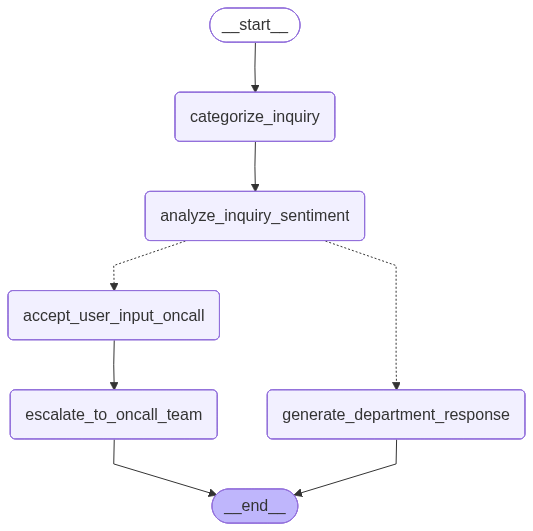

In [38]:
compiled_support_agent

In [39]:
from IPython.display import Markdown

In [40]:
def call_support_agent(agent, prompt, user_session_id, verbose=False):
    # Stream the compiled graph and render the final Markdown answer.
    # Use thread_id so repeated calls share memory/ckpts if desired.
    events = agent.stream(
        {"customer_query": prompt}, # initial state of the agent
        {"configurable": {"thread_id": user_session_id}},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
                print(event)


    print('\nFinal Response:')
    display(Markdown(event['final_response']))

In [41]:
[item[0]['doc'] for item in knowledge_base]

["Q: How do I access my annual leave balance?\nA1: Your current annual leave balance is available on the HR employee portal, typically under the 'Leave' or 'Time Off' section. It's updated in real-time after each request is processed.",
 "Q: I can't log in to my computer/work applications. What should I do?\nA1: First, try restarting your computer. If the issue persists, ensure you're using the correct username and password. If you've forgotten your password or believe your account is locked, please use the 'Forgot Password' link on the login page or contact the IT Helpdesk immediately at [IT Helpdesk Phone Number] or [IT Helpdesk Email].",
 'Q: How do I report a maintenance issue in the office/store (e.g., a broken light, leaky tap)?\nA1: You can report any maintenance issues via the Facilities Request Portal on the company intranet. Please provide as much detail as possible, including location and a description of the problem. For urgent issues that pose an immediate safety risk, ple

In [42]:
uid = 'shima002'
query = "How do I report a maintenance issue in the office/store (e.g., a broken light, leaky tap)?"
call_support_agent(agent=compiled_support_agent,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'customer_query': 'How do I report a maintenance issue in the office/store (e.g., a broken light, leaky tap)?'}
{'customer_query': 'How do I report a maintenance issue in the office/store (e.g., a broken light, leaky tap)?', 'query_category': 'FACILITY_AND_ADMIN'}
{'customer_query': 'How do I report a maintenance issue in the office/store (e.g., a broken light, leaky tap)?', 'query_category': 'FACILITY_AND_ADMIN', 'query_sentiment': 'Neutral'}
{'customer_query': 'How do I report a maintenance issue in the office/store (e.g., a broken light, leaky tap)?', 'query_category': 'FACILITY_AND_ADMIN', 'query_sentiment': 'Neutral', 'final_response': 'To report a maintenance issue in the office or store, such as a broken light or leaky tap, please use the Facilities Request Portal available on the company intranet. When submitting your request, ensure you provide as much detail as possible, including the specific location and a description of the problem. If the is

To report a maintenance issue in the office or store, such as a broken light or leaky tap, please use the Facilities Request Portal available on the company intranet. When submitting your request, ensure you provide as much detail as possible, including the specific location and a description of the problem. If the issue is urgent and poses an immediate safety risk, it is important to also notify your manager and contact Facilities directly at the urgent phone number provided by your company. This will help ensure the issue is addressed promptly.